In [19]:
 %load_ext autoreload

In [20]:
%autoreload 2

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import urllib
from bs4 import BeautifulSoup
import requests
from astropy.io import fits
from astropy.table import Table
import glob
import scipy.integrate
import scipy.stats
import scipy.interpolate
import scipy.optimize
import scipy.signal
import scipy.ndimage
import scipy.spatial
import seaborn as sns
#---------------- aux files ------------------------
import AuxFunctions as aux
from ProfileClass import PulsarProfile
from WidthMonteCarloClass import WidthDistributionGenerator

# Auxilary functions

In [22]:
def is_float(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

# ATNF Database

In [23]:
lines = []
with open('psrcat.db') as f:
    lines = f.readlines()
dict_list = []
tmp_dict = {}
for line in lines:
    if len(line,) == 0:
        print("ERROR: Zero length line")
        break
    if line[0] == '@':
        dict_list.append(tmp_dict)
        tmp_dict = {}
    else:
        splitted_line = line.split()
        if(is_float(splitted_line[1])):
            tmp_dict[splitted_line[0]] = float(splitted_line[1])
        else:
            tmp_dict[splitted_line[0]] = splitted_line[1]
data = pd.DataFrame(dict_list)
data.loc[data['F0'].notna(), 'P0'] = 1 / data['F0']
data.loc[data['P0'].notna(), 'F0'] = 1 / data['P0']
data.loc[data['F0'].notna() & data['F1'].notna(), 'P1'] = -data['F1'] / data['F0']**2 
data.loc[data['P0'].notna() & data['P1'].notna(), 'F1'] = -data['P1'] / data['P0']**2

data['B12'] = (data['P0'] * data['P1'] * 1e15)**0.5
data['AGE'] = data['P0'] / data['P1'] / 2
data['Q'] = data['P0']**(5/7) / (data['P1']*1e15)**(2/7)
data['L1400'] = data['S1400'] * data['DIST_DM']**2
data['L'] = 7.4e27 * data['L1400']
data['Edot'] = 3.95 * 1e31 * (data['P1'] / 1e-15)/ data['P0']**3
data['Eff'] = data['L'] / data['Edot']
data = data.set_index('PSRJ')

In [24]:
data[(data['P0'] > 0.03) & (data['P0'] < 0.5)]

RAJ           DECJ  POSEPOCH  PMRA  PMDEC        DM  \
PSRJ                                                                        
J0002+6216    00:02:58.17    +62:16:09.4   55806.0  32.5  -13.7  218.6000   
J0007+7303     00:07:01.7    +73:03:07.4       NaN   NaN    NaN       NaN   
J0026+6320   00:26:50.561   +63:20:00.87       NaN   NaN    NaN  245.0600   
J0032+6946  00:32:41.2477  +69:46:28.047   56736.0   NaN    NaN   79.9988   
J0033+57            00:33           57.0       NaN   NaN    NaN   75.6500   
...                   ...            ...       ...   ...    ...       ...   
J2326+6243   23:26:41.492   +62:43:22.49   57234.0   NaN    NaN  193.6100   
J2327+62            23:27           62.0       NaN   NaN    NaN  193.4000   
J2337+6151   23:37:05.762   +61:51:01.53   53100.0  -1.0  -15.0   58.4100   
J2338+4818   23:38:06.189   +48:18:32.19       NaN   NaN    NaN   35.3000   
J2340+08         23:40:45       08:33:00       NaN   NaN    NaN   22.9000   

                   F0     PEPOCH            F1   PX  ...  DM5  ECCDOT  DTHETA  \
PSRJ                                                 ...                        
J0002+6216   8.668248  55806.000 -4.483540e-13  0.6  ...  NaN     NaN     NaN   
J0007+7303   3.165827  54952.000 -3.612000e-12  NaN  ...  NaN     NaN     NaN   
J0026+6320   3.141120  56675.000 -1.486000e-15  NaN  ...  NaN     NaN     NaN   
J0032+6946  27.171119        NaN -2.650134e-15  NaN  ...  NaN     NaN     NaN   
J0033+57     3.174603  54100.000           NaN  NaN  ...  NaN     NaN     NaN   
...               ...        ...           ...  ...  ...  ...     ...     ...   
J2326+6243   3.757291        NaN -3.628430e-14  NaN  ...  NaN     NaN     NaN   
J2327+62     3.759398        NaN           NaN  NaN  ...  NaN     NaN     NaN   
J2337+6151   2.018694  54521.000 -7.883320e-13  NaN  ...  NaN     NaN     NaN   
J2338+4818   8.423872  58909.654 -1.400000e-16  NaN  ...  NaN     NaN     NaN   
J2340+08     3.297066  56098.000           NaN  NaN  ...  NaN     NaN     NaN   

                  B12           AGE         Q      L1400             L  \
PSRJ                                                                     
J0002+6216   0.829686  9.666745e+12  0.128352   0.889052  6.578984e+27   
J0007+7303  10.669474  4.382375e+11  0.081659        NaN           NaN   
J0026+6320   0.218969  1.056904e+15  0.758298  43.811161  3.242026e+29   
J0032+6946   0.011494  5.126367e+15  0.472274        NaN           NaN   
J0033+57          NaN           NaN       NaN        NaN           NaN   
...               ...           ...       ...        ...           ...   
J2326+6243   0.827079  5.177572e+13  0.296648        NaN           NaN   
J2327+62          NaN           NaN       NaN        NaN           NaN   
J2337+6151   9.789240  1.280358e+12  0.134520   6.051137  4.477842e+28   
J2338+4818   0.015304  3.008526e+16  1.293443        NaN           NaN   
J2340+08          NaN           NaN       NaN        NaN           NaN   

                    Edot           Eff  
PSRJ                                    
J0002+6216  1.535145e+35  4.285578e-08  
J0007+7303  4.516813e+35           NaN  
J0026+6320  1.843743e+32  1.758393e-03  
J0032+6946  2.844281e+33           NaN  
J0033+57             NaN           NaN  
...                  ...           ...  
J2326+6243  5.385062e+33           NaN  
J2327+62             NaN           NaN  
J2337+6151  6.286033e+34  7.123478e-07  
J2338+4818  4.658401e+31           NaN  
J2340+08             NaN           NaN  

[1230 rows x 164 columns]

# Pulsars mean profiles database (.fits)

# FAST profiles

In [25]:
# ----downloading-----
# url = 'http://zmtt.bao.ac.cn/psr-fast/'
# reqs = requests.get(url)
# soup = BeautifulSoup(reqs.text, 'html.parser')
 
# urls = []
# for link in soup.find_all('a'):
#     link_string = link.get('href')
#     if link_string.split('/')[0] == 'whx23dat':
#         print(link_string.split('/')[1])
#         urllib.request.urlretrieve(url+link_string, 'FAST_profiles/' + link_string.split('/')[1])

In [26]:
data.loc['J1827+00'] = pd.Series({'P0': 0.375})
data.loc['J1934+09'] = pd.Series({'P0': 0.0046})
data.loc['J1826-00'] = pd.Series({'P0': 0.0045})
data.loc['J2041+46'] = pd.Series({'P0': 1.159})
data.loc['J1854-01'] = pd.Series({'P0': 0.680})
data.loc['J1849+0340g'] = pd.Series({'P0': 1.666})
data.loc['J1919+04'] = pd.Series({'P0': 0.0039})
data.loc['J1943+28'] = pd.Series({'P0': 0.737})
data.loc['J1944+16'] = pd.Series({'P0': 0.0024})
data.loc['J1852-0054g'] = pd.Series({'P0': 0.164})
data.loc['J1907+0555'] = pd.Series({'P0': 0.168})
data.loc['J1938+14A'] = pd.Series({'P0': 1.661})
data.loc['J1917+24'] = pd.Series({'P0': 0.0043})
data.loc['J1836+09'] = pd.Series({'P0': 0.541})
data.loc['J2021+24'] = pd.Series({'P0': 0.879})
data.loc['J1958+2213'] = pd.Series({'P0': 1.05})
data.loc['J1843+04'] = pd.Series({'P0': 0.397})
data.loc['J1858-02'] = pd.Series({'P0': 1.462})
data.loc['J2025+2133'] = pd.Series({'P0': 0.623})
data.loc['J1929+1905'] = pd.Series({'P0': 0.339})
data.loc['J0625+17'] = pd.Series({'P0': 2.518})
data.loc['J2108+41'] = pd.Series({'P0': 1.511})
data.loc['J1921+1540'] = pd.Series({'P0': 0.143})
data.loc['J2005+38'] = pd.Series({'P0': 2.461})




In [27]:
FASTfiles = glob.glob('FAST_Profiles/*')
FASTnames = []
for file in FASTfiles:
    name = file.split('/')[1]
    name = name.split('I')[0]
    name = name.replace('p', '+')
    name = name.replace('m', '-')
    FASTnames.append(name)
FASTProfiles = pd.DataFrame({'PSRJ': FASTnames, 'file_name': FASTfiles})
FASTProfiles = FASTProfiles.set_index('PSRJ')
FASTTable = pd.read_csv('KAT?.csv')
FASTTable.set_index('PSRJ', inplace=True)
FASTTable = FASTTable[~FASTTable.index.duplicated(keep='first')]
print(FASTTable)
FASTTable.rename(columns={'W10': 'W10_custom'}, inplace=True) #do not exist in Table!!!
FASTProfiles = FASTProfiles.merge(FASTTable, how='left', left_index=True, right_index=True)

            Mode
PSRJ            
J0011+08      Od
J0848+16     Od?
J1312+1810A   Od
J1538+2345    Od
J1641+3627A   Od
...          ...
J2129+1210A    ?
J2129+4119     ?
J2138+4911     ?
J2208+4056    Os
J2340+08       ?

[195 rows x 1 columns]


## MeerKAT profiles

In [28]:
MeerKATfiles = glob.glob('MeerKAT_Profiles/ar_files/*')
MeerKATnames = []
for file in MeerKATfiles:
    MeerKATnames.append(file.split('/')[2].split('_')[0])
MeerKATProfiles = pd.DataFrame({'PSRJ': MeerKATnames, 'file_name': MeerKATfiles})
MeerKATTable = pd.read_csv('MeerKat.csv')
MeerKATTable.set_index('PSRJ', inplace=True)
MeerKATTable.rename(columns={'W10': 'W10_custom'}, inplace=True)

MeerKATProfiles = MeerKATProfiles.set_index('PSRJ')
MeerKATProfiles = MeerKATProfiles.merge(MeerKATTable, how='left', left_index=True, right_index=True)

In [29]:
MeerKATTable1 = pd.read_csv('Census_Table1.csv')
MeerKATTable1.set_index('PSRJ', inplace=True)
data = pd.concat([MeerKATTable1['P'], data], axis=1)
data.loc[data['P0'].isna(), 'P0'] = data['P']
data = data.drop(columns=['P'])

In [30]:
MeerKATProfiles.loc['J1638-4725']
'J1638-4725' in MeerKATnames

True

In [31]:
data.loc['J0514-4407', 'P0']

0.3203

## EPN profiles

In [32]:
EPN_PSR_folders = glob.glob('EPN_ALL/fits/**/*')

In [33]:
EPNnames = []
for folder in EPN_PSR_folders:
    name = folder.split('/')[-1]
    if name[0] == 'B':
        name = data.index[data['PSRB'] == name][0]
    EPNnames.append(name)

# EPN_Profiles = pd.DataFrame({'PSRJ': EPNnames, 'EPNfolder': EPN_PSR_folders})
# EPN_Profiles = EPN_Profiles.set_index('PSRJ')

In [34]:
EPN_Profiles_dict = dict.fromkeys(EPNnames, [])
for i in range(len(EPN_PSR_folders)):
    folder = EPN_PSR_folders[i]
    files = glob.glob(folder+'/*')
    EPN_Profiles_dict[EPNnames[i]] = EPN_Profiles_dict[EPNnames[i]] + files #!!! do not use += 

# Useful subsets

## Fast and MeerKAT subsets

In [35]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()

## FAST orthogonal subset

In [23]:
orthogonal_PSRs_FAST = []
for psr in FASTnames:
    profile = PulsarProfile(FASTProfiles.loc[psr]['file_name'], 'FAST')
    if profile.profile_type == 'orthogonal':
        orthogonal_PSRs_FAST.append(psr)
orthogonalFASTs = data[data.index.isin(orthogonal_PSRs_FAST)].copy()
print(np.sort(np.array(orthogonal_PSRs_FAST)))


['J0337+1715' 'J0653+4706' 'J0827+53' 'J1628+4406' 'J1630+3734'
 'J1710+4923' 'J1842+0358' 'J1849+0409' 'J1851+0118' 'J1851+0418'
 'J1852+0056g' 'J1853+1303' 'J1855+0700' 'J1857+0943' 'J1858-0024g'
 'J1909+0749' 'J1913+0832' 'J1913+1050' 'J1918+1541' 'J1921+0137'
 'J1926+0737' 'J1932+1059' 'J1934+2352' 'J1935+1726' 'J1935+2025'
 'J1939+2134' 'J1955+2908' 'J1959+2048' 'J2004+3429' 'J2023+5037'
 'J2032+4127' 'J2047+5029' 'J2053+4650' 'J2208+4056']


/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


256
[0.25       0.74609375]
0.012392829969251373
10.828125
O
0.73046875 0.76171875


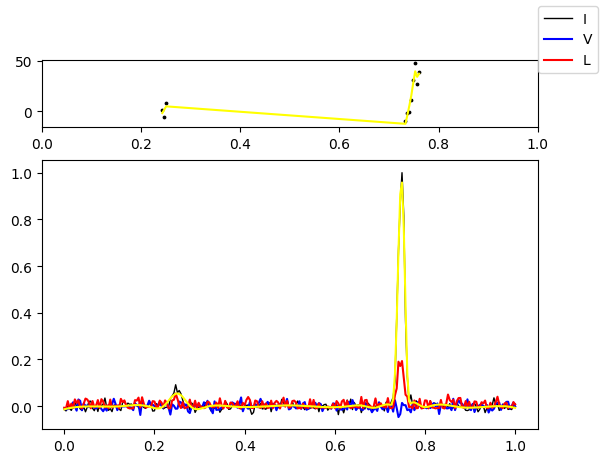

In [34]:
profile = PulsarProfile(FASTProfiles.loc['J1855+0700']['file_name'], 'FAST')
profile.plot_profile(plot_fit=True)
print(profile.Ncounts)
print(profile.find_peaks()/profile.Ncounts)
print(aux.noise_estimation(profile.I))
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)

## MeerKAT orthogonal subset

In [35]:
orthogonal_PSRs_MeerKAT = []
for psr in MeerKATnames:
    if not psr in data.index:
        continue
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['file_name'], 'MeerKAT')
    if profile.profile_type == 'orthogonal':
        # plt.plot(np.linspace(0, 1, pulsar_data[0].shape[0]), pulsar_data[0])
        orthogonal_PSRs_MeerKAT.append(psr)
orthogonalMeerKATs = data[data.index.isin(orthogonal_PSRs_MeerKAT)].copy()
print(np.sort(np.array(orthogonal_PSRs_MeerKAT)))
orthogonal_PSRs_MeerKAT += ['J1918+1541', 'J1851+0418', 'J1611-5209', 'J1828-1101', 'J0514-4407']


['J0514-4407' 'J0627+0706' 'J0835-3707' 'J0842-4851' 'J0905-5127'
 'J0908-4913' 'J1057-5226' 'J1126-6054' 'J1413-6307' 'J1549-4848'
 'J1637-4553' 'J1705-1906' 'J1722-3712' 'J1739-2903' 'J1755-0903'
 'J1816-0755' 'J1825-0935' 'J1842+0358' 'J1843-0702' 'J1849+0409'
 'J1909+0749' 'J1913+0832' 'J1926+0737' 'J1932+1059' 'J1935+2025']


In [17]:
orthogonal_PSRs_MeerKAT = list(set(orthogonal_PSRs_MeerKAT))

/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


1024
1.3513162111587467
235.3359375
[0.04589844 0.70019531]
[0.09472656]
single


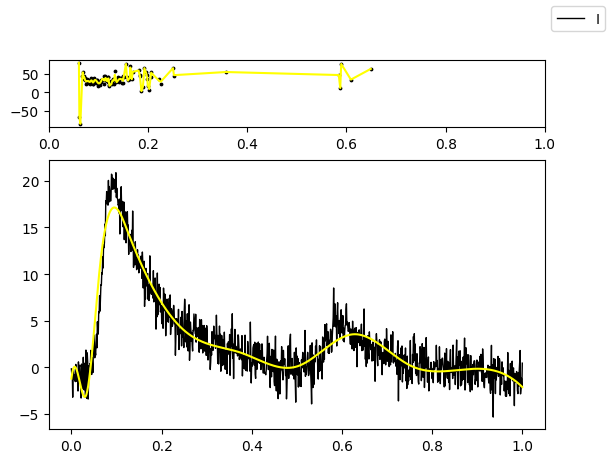

In [ ]:
profile = PulsarProfile(MeerKATProfiles.loc['J1828-1101']['file_name'], 'MeerKAT')
profile.plot_profile(plot_fit=True, plot_pol=False)
print(profile.Ncounts)
print(aux.noise_estimation(profile.I))
print(profile.get_Wa(10))
print(np.array(profile.get_level_bounds(10))/profile.Ncounts)
print(profile.find_peaks()/profile.Ncounts)
print(profile.find_profile_type())

## Fast and MeerKAT manual mode subsets

In [16]:
MeerKATXs = MeerKATsubset.loc[MeerKATProfiles[(MeerKATProfiles['Mode'] == 'Xd') | (MeerKATProfiles['Mode'] == 'Xs')].index]
MeerKATOs = MeerKATsubset.loc[MeerKATProfiles[(MeerKATProfiles['Mode'] == 'Od') | (MeerKATProfiles['Mode'] == 'Os')].index]
FASTXs = FASTsubset.loc[FASTProfiles[(FASTProfiles['Mode'] == 'Xd') | (FASTProfiles['Mode'] == 'Xs')].index]
FASTOs = FASTsubset.loc[FASTProfiles[(FASTProfiles['Mode'] == 'Od') | (FASTProfiles['Mode'] == 'Os')].index]

# Profiles processing

# Space for working

# Width Statistics

In [188]:
PXs = []
PdotXs = []
PXd = []
PdotXd = []
POs = []
PdotOs = []
POd = []
PdotOd = []
for index, psr in MeerKATProfiles.iterrows():
    if psr['Mode'] == 'Xs':
        PXs.append(data.loc[index]['P0'])
        PdotXs.append(data.loc[index]['P1'])
    elif psr['Mode'] == 'Xd':
        PXd.append(data.loc[index]['P0'])
        PdotXd.append(data.loc[index]['P1'])
    elif psr['Mode'] == 'Os':
        POs.append(data.loc[index]['P0'])
        PdotOs.append(data.loc[index]['P1'])
    elif psr['Mode'] == 'Od':
        POd.append(data.loc[index]['P0'])
        PdotOd.append(data.loc[index]['P1'])

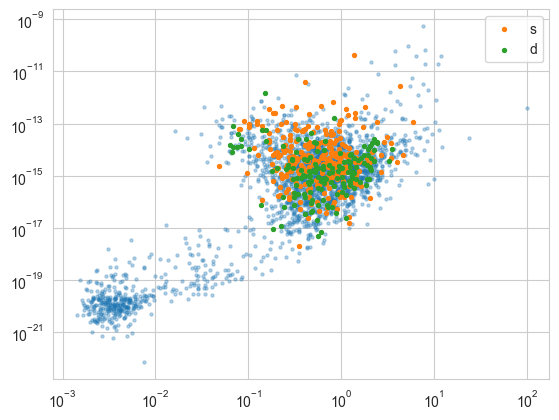

In [203]:
plt.scatter(data['P0'], data['P1'], s=5, alpha=0.3)
# plt.scatter(PXs, PdotXs, s=8, label='Xs')
# plt.scatter(POs, PdotOs, s=8, label='Os')
# plt.scatter(PXd, PdotXd, s=8, label='Xd')
# plt.scatter(POd, PdotOd, s=8, label='Od')

# plt.scatter(PXs + PXd, PdotXs + PdotXd, s=8, label='X')
# plt.scatter(POs + POd, PdotOs + PdotOd, s=8, label='O')

plt.scatter(PXs + POs, PdotXs + PdotOs, s=8, label='s')
plt.scatter(PXd + POd, PdotXd + PdotOd, s=8, label='d')

plt.xscale('log')
plt.yscale('log')
plt.legend()

In [142]:
def get_width_samples(ProfileDataBase, source, width=10, mode_info='external', sd_diff=False, P_power=0.5, Pmin=0.03, Pmax=10):
    Xs = []
    Xd = []
    Os = []
    Od = []
    POs = []
    PXs = []
    for index, psr in ProfileDataBase.iterrows():
        pulsar_profile = PulsarProfile(psr['file_name'], source)
        if not (index in data.index):
            continue
        if data.loc[index]['P0'] < Pmin or data.loc[index]['P0'] > Pmax:
            continue
        if mode_info == 'external':
            if pulsar_profile.get_Wa(width) * data.loc[index]['P0']**P_power < 60:
                reduced_width = pulsar_profile.get_Wa(width) * data.loc[index]['P0']**P_power
                if psr['Mode'] == 'Xs':
                    Xs.append(reduced_width)
                    PXs.append(data.loc[index]['P0'])
                if psr['Mode'] == 'Xd':
                    Xd.append(reduced_width)
                    PXs.append(data.loc[index]['P0'])
                if psr['Mode'] == 'Os':
                    Os.append(reduced_width)
                    POs.append(data.loc[index]['P0'])
                if psr['Mode'] == 'Od':
                    Od.append(reduced_width)
                    POs.append(data.loc[index]['P0'])
        elif mode_info == 'from_profile':
            if pulsar_profile.get_Wa(width) * data.loc[index]['P0']**P_power < 60:
                reduced_width = pulsar_profile.get_Wa(width) * data.loc[index]['P0']**P_power
                if pulsar_profile.find_profile_type() == 'single':
                    mode = pulsar_profile.get_mode()
                    if mode == 'X':
                        Xs.append(reduced_width)
                        PXs.append(data.loc[index]['P0'])
                    if mode == 'O':
                        Os.append(reduced_width)
                        POs.append(data.loc[index]['P0'])
                elif pulsar_profile.find_profile_type() == 'double':
                    mode = pulsar_profile.get_mode()
                    if mode == 'X':
                        Xd.append(reduced_width)
                        PXs.append(data.loc[index]['P0'])
                    if mode == 'O':
                        Od.append(reduced_width)
                        POs.append(data.loc[index]['P0'])
    if sd_diff:
        return Xs, Xd, Os, Od
    else:
        return Xs + Xd, Os + Od

In [143]:
MeerKAT_XW10, MeerKAT_OW10 = get_width_samples(MeerKATProfiles, 'MeerKAT', mode_info='external', P_power=0.25)
FAST_XW10, FAST_OW10 = get_width_samples(FASTProfiles, 'FAST', mode_info='external', P_power=0.25)

KeyboardInterrupt: 

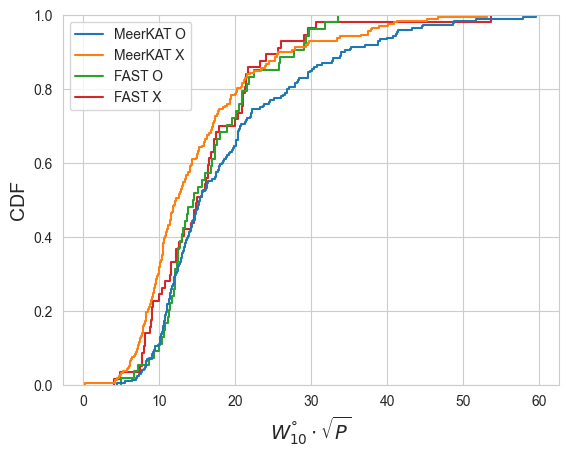

In [124]:
sns.ecdfplot({'MeerKAT O': MeerKAT_OW10, 'MeerKAT X':MeerKAT_XW10,'FAST O':FAST_OW10, 'FAST X':FAST_XW10}, palette='tab10')
plt.ylabel('CDF', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
plt.savefig('CDF_Both.png', dpi=400, bbox_inches='tight')


## P dependance

In [116]:
XW10, OW10, PXs, POs  = get_width_samples(FASTProfiles, 'FAST', mode_info='from_profile', width=10, Pmin=0.03, Pmax=10, P_power=0.0)

In [117]:
print(np.median(PXs), np.median(POs))
print(np.mean(PXs), np.mean(POs))

0.5466 1.0740800763472516
0.7384417354940987 1.3608633072088852


<Axes: ylabel='Density'>

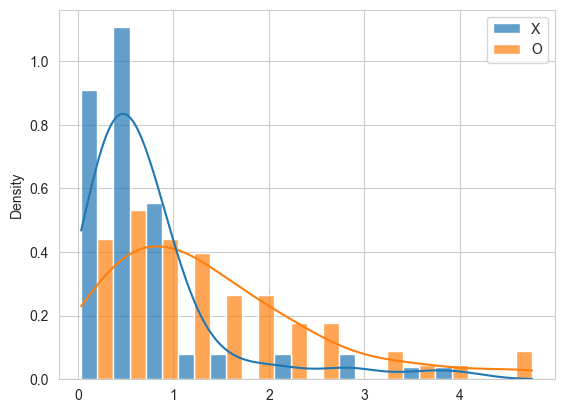

In [118]:
sns.histplot({'X':PXs, 'O':POs}, kde=True, alpha=0.7, stat='density', palette='tab10', multiple="dodge", common_norm=False)

In [180]:
XW10_1, OW10_1  = get_width_samples(FASTProfiles, 'FAST', mode_info='external', width=10, Pmin=0.03, Pmax=0.3, P_power=0)
XW10_2, OW10_2 = get_width_samples(FASTProfiles, 'FAST', mode_info='external', width=10, Pmin=0.3, Pmax=0.6, P_power=0)
# XW10, OW10 = get_width_samples(MeerKATProfiles, 'MeerKAT', mode_info='external', width=10, Pmin=0.03, Pmax=10, P_power=0.25)

18 7
17 7
18.791015625 23.90625
20.53125 25.03125


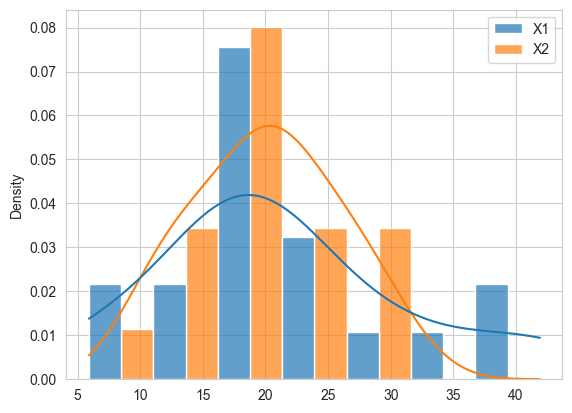

In [181]:
print(len(XW10_1), len(OW10_1))
print(len(XW10_2), len(OW10_2))
sns.histplot({'X1': XW10_1, 'X2':XW10_2}, kde=True, alpha=0.7, stat='density', palette='tab10', multiple="dodge", common_norm=False)
print(np.median(XW10_1), np.median(OW10_1))
print(np.median(XW10_2), np.median(OW10_2))

## Width statistics: FAST

In [132]:
XW10, OW10 = get_width_samples(FASTProfiles, 'FAST', mode_info='external', width=10, P_power=0.0)
XW50, OW50 = get_width_samples(FASTProfiles, 'FAST', mode_info='external', width=50, P_power=0.0)

In [133]:
def permutation_statistic(X, Y):
    n, m = len(X), len(Y)
    N = n + m
    sigmaX2, sigmaY2 = np.var(X), np.var(Y)
    return np.sqrt(N) * (np.mean(Y) - np.mean(X)) / np.sqrt(N / n * sigmaX2 + N / m * sigmaY2)

In [134]:
def permutation_statistic_median(X, Y):
    n, m = len(X), len(Y)
    N = n + m
    sigmaX2, sigmaY2 = scipy.stats.bootstrap((X,), np.median, method='percentile', n_resamples=100).standard_error**2, scipy.stats.bootstrap((Y,), np.median, method='percentile', n_resamples=100).standard_error**2
    return np.sqrt(N) * (np.median(Y) - np.median(X)) / np.sqrt(N / n * sigmaX2 + N / m * sigmaY2)

In [135]:
# print(Nall, Ntrue, Ncomm, Ntrue / Ncomm)
print(len(XW50), len(OW50))

60 56


In [138]:
XW10 = np.sort(XW10)
OW10 = np.sort(OW10)
print(len(XW10), len(OW10))
NX = len(XW10)
NO = len(OW10)
print(np.median(XW10), XW10[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW10[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW10), OW10[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW10[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
print(np.mean(XW10), np.mean(OW10))
# print(scipy.stats.bootstrap((XW10,), np.median, method='percentile'))
# print(scipy.stats.bootstrap((XW10,), np.median, method='basic'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='basic'))

56 54
18.0615234375 16.20703125 20.53125
14.30859375 12.4453125 17.3671875
18.532052176339285 17.8369140625


In [139]:
XW50 = np.sort(XW50)
OW50 = np.sort(OW50)
print(len(XW50), len(OW50))
NX = len(XW50)
NO = len(OW50)
print(np.median(XW50), XW50[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW50[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW50), OW50[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW50[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
print(np.mean(XW50), np.mean(OW50))

60 56
9.84375 7.76953125 12.234375
8.82421875 7.576171875 11.6015625
11.20546875 10.136614118303571


KstestResult(statistic=0.2156084656084656, pvalue=0.12723725272710293, statistic_location=15.9609375, statistic_sign=-1)
TtestResult(statistic=0.3935933160995484, pvalue=0.6526713619956299, df=108.0)
TtestResult(statistic=0.392026482989276, pvalue=0.6520696916024742, df=101.49430375960752)
Anderson_ksampResult(statistic=0.6594090293940946, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.17645470229946453)
PermutationTestResult(statistic=-3.7529296875, pvalue=0.9897, null_distribution=array([-0.20214844, -1.30957031, -0.30761719, ...,  0.39550781,
       -3.97265625,  0.53613281]))
PermutationTestResult(statistic=-0.6951381138392847, pvalue=0.6467, null_distribution=array([ 1.49933733,  0.23776972, -2.09354074, ...,  0.54404994,
       -0.01799665,  2.30819847]))


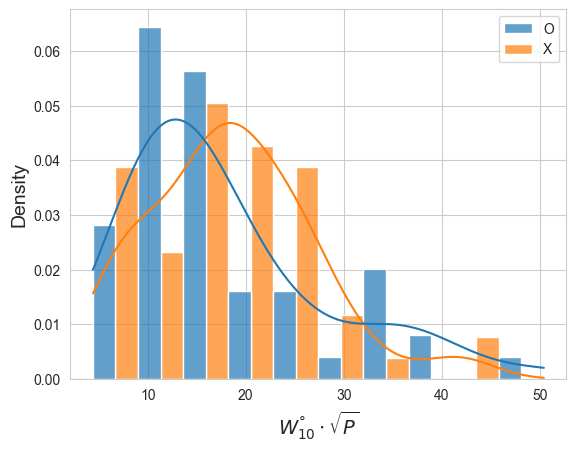

In [141]:
sns.histplot({'O': OW10, 'X':XW10}, kde=True, alpha=0.7, stat='density', palette='tab10', multiple="dodge", common_norm=False)
sns.set_style("whitegrid")
plt.grid(True)
# ax2 = plt.twinx()
# ax2.grid(False)
# sns.ecdfplot({'O': OW10, 'X':XW10}, alpha=0.7, palette='tab10', ax=ax2)
plt.ylabel('Density', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
print(scipy.stats.kstest(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10, alternative='less'))
print(scipy.stats.ttest_ind(XW10, OW10, equal_var=False, alternative='less'))
print(scipy.stats.anderson_ksamp([XW10, OW10]))
print(scipy.stats.permutation_test((XW10, OW10), lambda x, y: np.median(y) - np.median(x), alternative='greater'))
print(scipy.stats.permutation_test((XW10, OW10), lambda x, y: np.mean(y) - np.mean(x), alternative='greater'))
# print(scipy.stats.permutation_test((XW10, OW10), permutation_statistic, alternative='greater'))
# print(scipy.stats.permutation_test((XW10, OW10), permutation_statistic_median, alternative='greater'))



# plt.savefig('FAST_mode_comparison_manual.png', dpi=400, bbox_inches='tight')

KstestResult(statistic=0.1543859649122807, pvalue=0.4311829637341556, statistic_location=5.90625, statistic_sign=1)
TtestResult(statistic=-0.2657081343874524, pvalue=0.39546987528008826, df=115.0)
TtestResult(statistic=-0.2655662943328003, pvalue=0.39552560868782816, df=114.40078562688008)
Anderson_ksampResult(statistic=-0.5009179898787657, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.25)


/var/folders/th/pqmsqtjd3nv8k0cddm4sm9mh0000gn/T/ipykernel_31446/2943301740.py:9: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  print(scipy.stats.anderson_ksamp([XW50, OW50]))


PermutationTestResult(statistic=0.4212151415951517, pvalue=0.4052, null_distribution=array([ 0.97593742, -0.96125936,  1.05589397, ..., -0.67718537,
       -0.7555189 ,  1.06613505]))
PermutationTestResult(statistic=0.35033365199331, pvalue=0.3983, null_distribution=array([-2.50163691, -0.11287846, -0.7367457 , ...,  1.07551598,
        0.87705386, -1.14902156]))


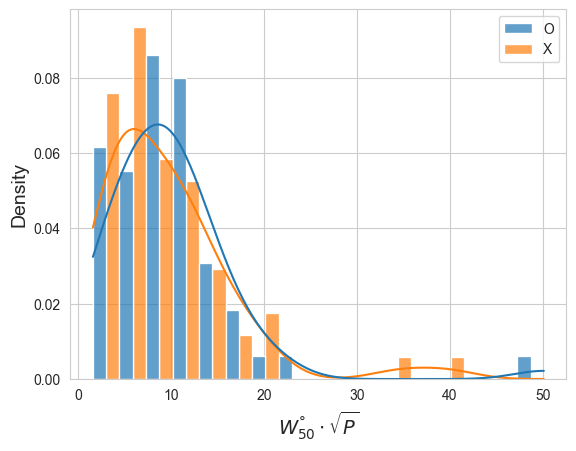

In [84]:
sns.histplot({'O': OW50, 'X':XW50}, kde=True, alpha=0.7, stat='density', palette='tab10', multiple="dodge", common_norm=False)
sns.set_style("whitegrid")
plt.grid(True)
plt.ylabel('Density', fontsize=14)
plt.xlabel(r'$W_{50}^\degree \cdot \sqrt{P}$', fontsize=14)
print(scipy.stats.kstest(XW50, OW50))
print(scipy.stats.ttest_ind(XW50, OW50, alternative='less'))
print(scipy.stats.ttest_ind(XW50, OW50, equal_var=False, alternative='less'))
print(scipy.stats.anderson_ksamp([XW50, OW50]))
print(scipy.stats.permutation_test((XW50, OW50), lambda x, y: np.median(y) - np.median(x), alternative='greater'))
print(scipy.stats.permutation_test((XW50, OW50), lambda x, y: np.mean(y) - np.mean(x), alternative='greater'))

Text(0.5, 0, '$W_{10}^\\degree \\cdot \\sqrt{P}$')

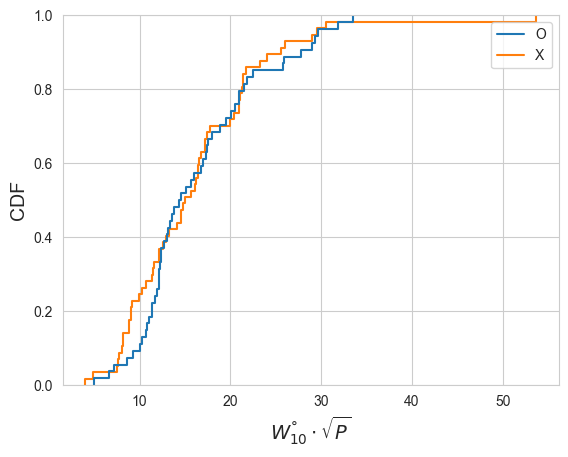

In [87]:
sns.ecdfplot({'O': OW10, 'X':XW10}, palette='tab10')
plt.ylabel('CDF', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
# plt.savefig('FAST_CDF_manual.png', dpi=400, bbox_inches='tight')

## Width statisticks MeerKAT

In [127]:
XW10, OW10 = get_width_samples(MeerKATProfiles, 'MeerKAT', mode_info='from_profile', width=10, P_power=0.25)
XW50, OW50 = get_width_samples(MeerKATProfiles, 'MeerKAT', mode_info='from_profile', width=50, P_power=0.25)

In [128]:
# print(Nall, Ntrue, Ncomm, Ntrue / Ncomm)
XW10 = np.sort(XW10)
OW10 = np.sort(OW10)
print(len(XW10), len(OW10))
NX = len(XW10)
NO = len(OW10)
print(np.median(XW10), XW10[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW10[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW10), OW10[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW10[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
# print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='basic'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))


83 73
12.068224987613542 10.624706325925917 13.822770592182112
13.160429950238925 12.066755120752806 15.558959079992741


In [129]:
XW50 = np.sort(XW50)
OW50 = np.sort(OW50)
print(len(XW50), len(OW50))
NX = len(XW50)
NO = len(OW50)
print(np.median(XW50), XW50[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW50[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW50), OW50[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW50[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
print(scipy.stats.bootstrap((OW50,), np.median, method='percentile'))
print(scipy.stats.bootstrap((XW50,), np.median, method='percentile'))
print(scipy.stats.bootstrap((OW50,), np.median, method='basic'))
print(scipy.stats.bootstrap((XW50,), np.median, method='basic'))

84 74
5.89843282176274 5.239795040197693 6.734416735009262
8.486133596607743 6.8528647377834995 10.130316912936207
BootstrapResult(confidence_interval=ConfidenceInterval(low=6.8528647377834995, high=10.02389173891354), bootstrap_distribution=array([6.95477378, 9.40504777, 6.57677793, ..., 9.40504777, 7.34275869,
       9.4680904 ]), standard_error=1.0110180894859362)
BootstrapResult(confidence_interval=ConfidenceInterval(low=5.101936385798296, high=6.746109597116584), bootstrap_distribution=array([6.03633234, 6.45337974, 5.89843282, ..., 5.67004664, 5.81132876,
       5.59545408]), standard_error=0.3449960224743938)
BootstrapResult(confidence_interval=ConfidenceInterval(low=6.948375454301948, high=10.119402455431988), bootstrap_distribution=array([8.76488437, 7.18287071, 9.25937848, ..., 7.01257087, 9.70565384,
       9.91746656]), standard_error=0.998860051288905)
BootstrapResult(confidence_interval=ConfidenceInterval(low=5.050756046408896, high=6.69144302178826), bootstrap_distributi

In [130]:
print(np.mean(XW10), np.mean(OW10), np.mean(XW50), np.mean(OW50))

13.698990995267534 15.534102553275975 7.270340876583246 9.702321548490403


KstestResult(statistic=0.16801452384881993, pvalue=0.1926859894522491, statistic_location=10.218059047032263, statistic_sign=1)
TtestResult(statistic=-1.6474102301366265, pvalue=0.10151268997669417, df=154.0)
TtestResult(statistic=-1.6239459557992424, pvalue=0.10667997300658899, df=137.3595934879214)
Anderson_ksampResult(statistic=0.8534089865376865, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.14588362085288276)
PermutationTestResult(statistic=1.8351115580084407, pvalue=0.0501, null_distribution=array([ 0.0270282 ,  0.61890702, -0.49137662, ...,  2.20108839,
       -0.78889924,  0.68585895]))
PermutationTestResult(statistic=1.6346937999612599, pvalue=0.0492, null_distribution=array([-0.86221276,  0.87995444, -2.21970388, ...,  0.75700477,
        0.19777935, -0.09011724]))


Text(0.5, 0, '$W_{10}^\\degree \\cdot \\sqrt{P}$')

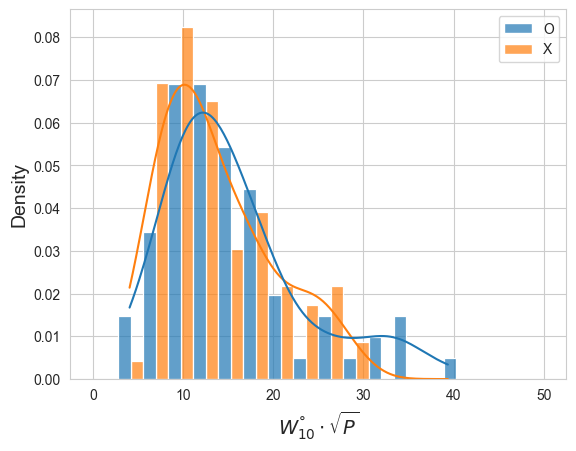

In [131]:
sns.histplot({'O': OW10, 'X':XW10}, kde=True, alpha=0.7, stat='density', palette="tab10", multiple="dodge", binrange=(0, 50), common_norm=False)
plt.ylabel('Density', fontsize=14)
print(scipy.stats.kstest(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10, equal_var=False))
print(scipy.stats.anderson_ksamp([XW10, OW10]))
print(scipy.stats.permutation_test((XW10, OW10), lambda x, y: np.mean(y) - np.mean(x), alternative='greater'))
print(scipy.stats.permutation_test((XW10, OW10), permutation_statistic, alternative='greater'))
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
# plt.savefig('MeerKAT_mode_comparison_manual.png', dpi=400, bbox_inches='tight')

In [199]:
def fit_func(W, W0):
    a = W/W0
    return a**(-3) * scipy.integrate.quad_vec(lambda t: (1-t**2)**2 / (1 - a**-(2) * (1 - t**2))**0.5, -1, 1)[0]

In [222]:
def W_dist(W, W0):
    t = W/W0
    if t == 1:
        t *= (1+1e-2)
    if t < 1:
        def integrand(y):
            return (1 - y**2)**(3/2) / np.sqrt(1 - t**2 * (1 - y**2))
        return t**2 * scipy.integrate.quad(integrand, 0, 1)[0]
    else:
        def integrand(y):
            return (1 - y**2)**(3/2) / np.sqrt(1 - t**(-2) * (1 - y**2))
        return t**(-3) * scipy.integrate.quad(integrand, 0, 1)[0]


KstestResult(statistic=0.2787878787878788, pvalue=7.250473353982283e-08, statistic_location=8.621651239781709, statistic_sign=1)
TtestResult(statistic=-6.012280902026538, pvalue=3.92279257802307e-09, df=428.0)
TtestResult(statistic=-5.958295609428447, pvalue=6.055677004211677e-09, df=361.210557424576)
Anderson_ksampResult(statistic=24.558738643537687, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)


/var/folders/th/pqmsqtjd3nv8k0cddm4sm9mh0000gn/T/ipykernel_31446/1367474162.py:10: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  print(scipy.stats.anderson_ksamp([XW50, OW50]))


PermutationTestResult(statistic=3.5757685076379966, pvalue=0.0001, null_distribution=array([ 0.6935055 , -0.32912522,  0.32944873, ...,  0.2830189 ,
       -0.23288578, -0.53462938]))


Text(0.5, 0, '$W_{50}^\\degree \\cdot \\sqrt{P}$')

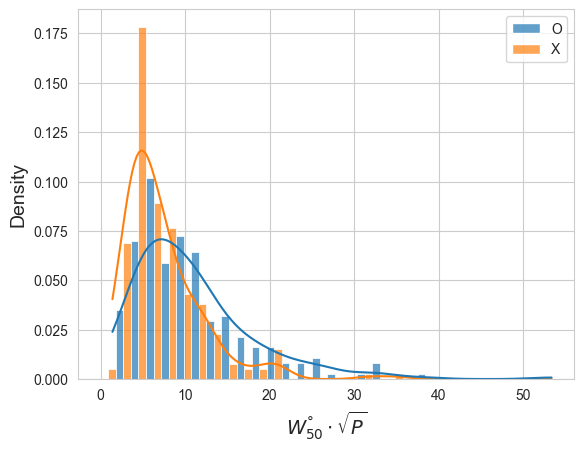

In [94]:
# W0 = 5
# Ws = np.linspace(1.1 * W0, 40, 100)
# plt.plot(Ws, 1e-1 * fit_func(Ws, 8), c='r')
sns.histplot({'O': OW50, 'X':XW50}, kde=True, alpha=0.7, stat='density', palette="tab10", multiple="dodge", binrange=(0, 50), common_norm=False)
plt.plot()
plt.ylabel('Density', fontsize=14)
print(scipy.stats.kstest(XW50, OW50))
print(scipy.stats.ttest_ind(XW50, OW50))
print(scipy.stats.ttest_ind(XW50, OW50, equal_var=False))
print(scipy.stats.anderson_ksamp([XW50, OW50]))
print(scipy.stats.permutation_test((XW50, OW50), lambda x, y: np.mean(y) - np.mean(x), alternative='greater'))
# print(scipy.stats.permutation_test((XW10, OW10), permutation_statistic, alternative='greater'))
plt.xlabel(r'$W_{50}^\degree \cdot \sqrt{P}$', fontsize=14)

In [434]:
Ws = np.linspace(0, 60, 1000)
dist_vals = np.zeros_like(Ws)
for i in range(Ws.shape[0]):
    dist_vals[i] = W_dist(Ws[i], 8.7)


/var/folders/th/pqmsqtjd3nv8k0cddm4sm9mh0000gn/T/ipykernel_69638/3252850550.py:2: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  plt.plot(Ws, dist_vals/scipy.integrate.trapz(dist_vals, Ws))


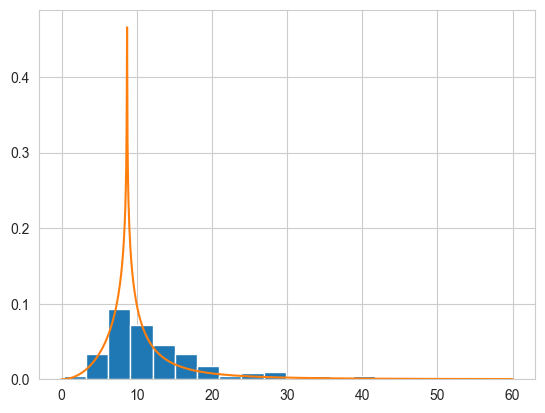

In [442]:
plt.hist(XW10, density=True, bins=20)
plt.plot(Ws, dist_vals/scipy.integrate.trapz(dist_vals, Ws))

/var/folders/th/pqmsqtjd3nv8k0cddm4sm9mh0000gn/T/ipykernel_69638/4180714231.py:5: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  CDFs = scipy.integrate.cumtrapz(dist_vals, Ws)


(0.01, 1.1)

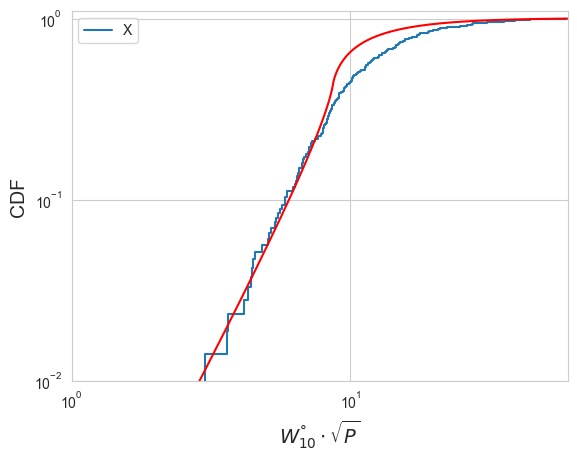

In [436]:

# sns.ecdfplot({'O': OW10, 'X':XW10}, palette='tab10')
sns.ecdfplot({'X':XW10}, palette='tab10')
plt.ylabel('CDF', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
CDFs = scipy.integrate.cumtrapz(dist_vals, Ws)
plt.plot(Ws[:-1], CDFs/np.max(CDFs), c='r', label='distribution')
# plt.savefig('MeerKAT_CDF_manual.png', dpi=400, bbox_inches='tight')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 60)
plt.ylim(1e-2, 1.1)


In [452]:
width_generator = WidthDistributionGenerator(100000)
width_generator.set_rho0(5)
width_generator.generate_psr_sample()
width_generator.generate_width_sample()

(1.0, 65.0)

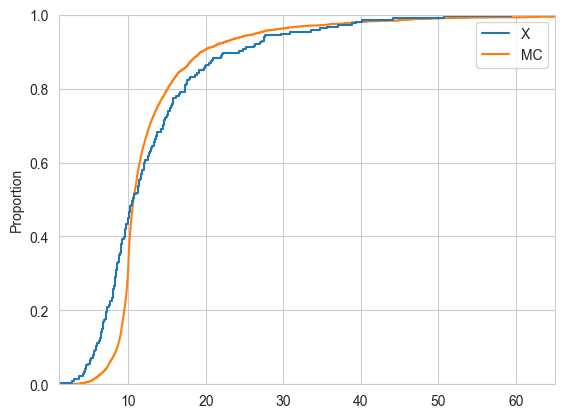

In [453]:
sns.ecdfplot({'X':XW10, 'MC':width_generator.get_Ws() * width_generator.get_Ps()**0.5}, palette='tab10')
plt.xlim(1, 65)
# plt.xscale('log')
# plt.yscale('log')

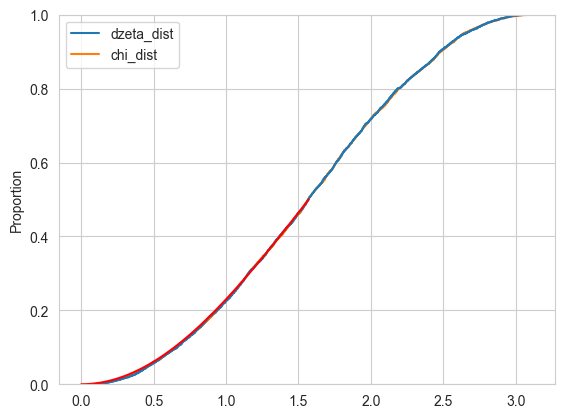

In [454]:
sns.ecdfplot({'dzeta_dist':width_generator.get_dzetas(), 'chi_dist':width_generator.get_chis()}, palette='tab10')
plt.plot(np.linspace(0, np.pi/2, 100), (1 - np.cos(np.linspace(0, np.pi/2, 100))) / 2, c='r')

<Axes: ylabel='Proportion'>

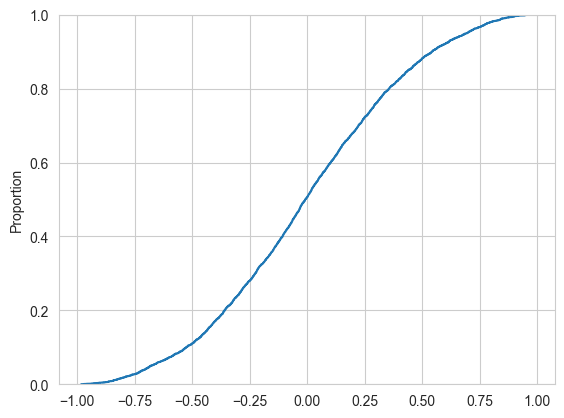

In [457]:
xs = width_generator.get_betas() / width_generator.get_rhos()
sns.ecdfplot(xs)

[ 5.72437498 10.         -1.69629645]


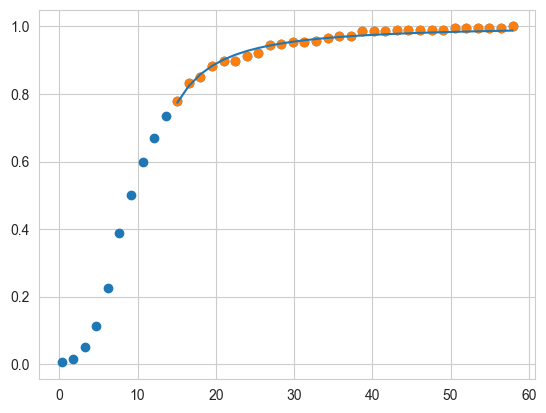

In [230]:
plt.scatter(widths, vals)
plt.scatter(widths[10:], vals[10:])
def fit_power_law(t, t0, a, degree):
    return 1-a * (t - t0)**(degree)
popt, pcov = scipy.optimize.curve_fit(fit_power_law, widths[10:], vals[10:], bounds=((0, 0, -5), (10, 10, 0)))
print(popt)
plt.plot(widths[10:], fit_power_law(widths[10:], *popt))
# plt.xscale('log')
# plt.yscale('log')

[0.23535156 0.23828125 0.24316406 0.24902344 0.25488281]
36.0
X
0.1982421875 0.2958984375


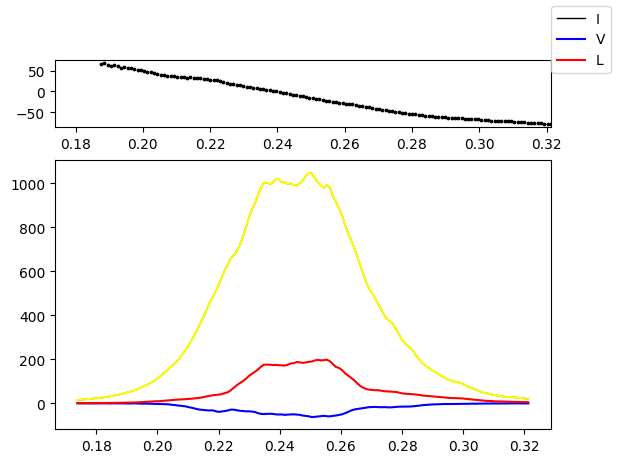

In [75]:
profile = PulsarProfile(MeerKATProfiles.loc['J0630-2834']['file_name'], 'MeerKAT')
profile.plot_profile(plot_fit=True, zoom=True)
print(profile.find_peaks()/profile.Ncounts)
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)


In [64]:
MultiHumped = []
TrippleHumped = []
for psr in MeerKATnames:
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['file_name'], 'MeerKAT')
    Nhumps = len(profile.find_peaks())
    if Nhumps >= 3:
        MultiHumped.append(psr)
    if Nhumps == 3:
        TrippleHumped.append(psr)

    

In [70]:
print(np.sort(np.array(MultiHumped)))

['J0401-7608' 'J0514-4407' 'J0525+1115' 'J0624-0424' 'J0627+0706'
 'J0630-2834' 'J0631+1036' 'J0726-2612' 'J0729-1836' 'J0738-4042'
 'J0742-2822' 'J0818-3232' 'J0901-4624' 'J0905-5127' 'J0907-5157'
 'J0908-4913' 'J0922-4949' 'J0924-5814' 'J0942-5552' 'J0953+0755'
 'J0955-5304' 'J1013-5934' 'J1034-3224' 'J1041-1942' 'J1043-6116'
 'J1048-5832' 'J1057-5226' 'J1121-5444' 'J1141-3322' 'J1146-6030'
 'J1157-6224' 'J1239+2453' 'J1248-6444' 'J1324-6302' 'J1326-6408'
 'J1326-6700' 'J1328-4921' 'J1336-2522' 'J1423-6953' 'J1456-6843'
 'J1536-3602' 'J1543+0929' 'J1557-4258' 'J1600-5751' 'J1604-4909'
 'J1605-5257' 'J1622-4347' 'J1625-4048' 'J1635-5954' 'J1646-6831'
 'J1703-3241' 'J1705-1906' 'J1707-4417' 'J1731-4744' 'J1740+1311'
 'J1744-1610' 'J1801-2920' 'J1803-2137' 'J1807-0847' 'J1808-3249'
 'J1809-1943' 'J1810-5338' 'J1812-3039' 'J1819+1305' 'J1823+0550'
 'J1825-0935' 'J1827-0750' 'J1829-1751' 'J1834-0426' 'J1843-0000'
 'J1845-0743' 'J1847-0402' 'J1849+0409' 'J1851+0418' 'J1852-0635'
 'J1900-09

In [72]:
print(np.sort(np.array(TrippleHumped)))


['J0514-4407' 'J0525+1115' 'J0627+0706' 'J0726-2612' 'J0729-1836'
 'J0738-4042' 'J0818-3232' 'J0905-5127' 'J0907-5157' 'J0908-4913'
 'J0922-4949' 'J0924-5814' 'J0942-5552' 'J0953+0755' 'J0955-5304'
 'J1013-5934' 'J1041-1942' 'J1043-6116' 'J1048-5832' 'J1141-3322'
 'J1146-6030' 'J1157-6224' 'J1324-6302' 'J1326-6408' 'J1326-6700'
 'J1328-4921' 'J1336-2522' 'J1423-6953' 'J1536-3602' 'J1543+0929'
 'J1557-4258' 'J1600-5751' 'J1604-4909' 'J1605-5257' 'J1622-4347'
 'J1635-5954' 'J1703-3241' 'J1705-1906' 'J1707-4417' 'J1731-4744'
 'J1740+1311' 'J1744-1610' 'J1803-2137' 'J1808-3249' 'J1812-3039'
 'J1819+1305' 'J1823+0550' 'J1825-0935' 'J1827-0750' 'J1829-1751'
 'J1843-0000' 'J1845-0743' 'J1847-0402' 'J1849+0409' 'J1851+0418'
 'J1852-0635' 'J1900-0933' 'J1900-2600' 'J1910+0358' 'J1918+1444'
 'J1919+0021' 'J1927+2234' 'J1932+1500' 'J1943+0609' 'J1946-2913'
 'J2006-0807' 'J2048-1616']


/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:85: UserWarning: FigureCanvasAgg is

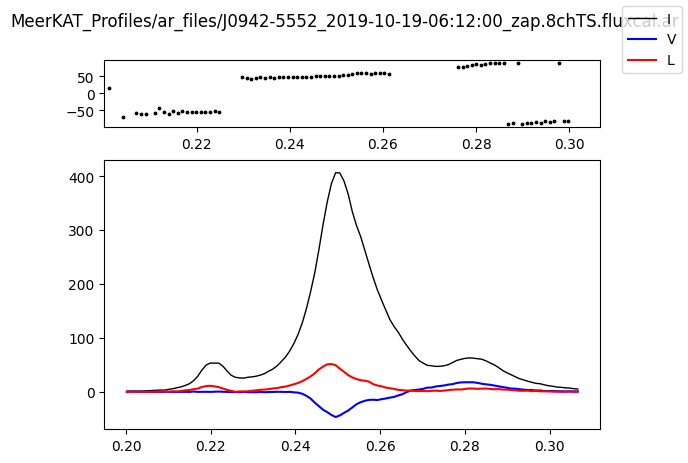

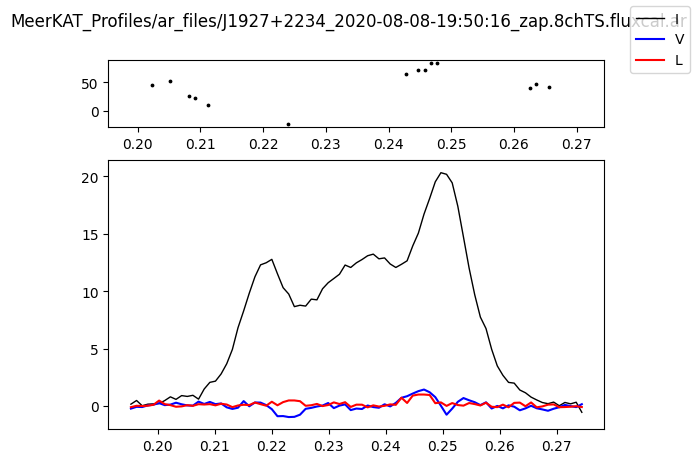

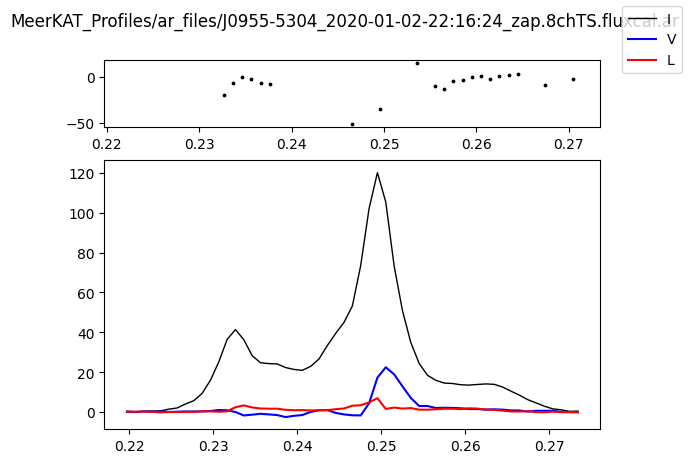

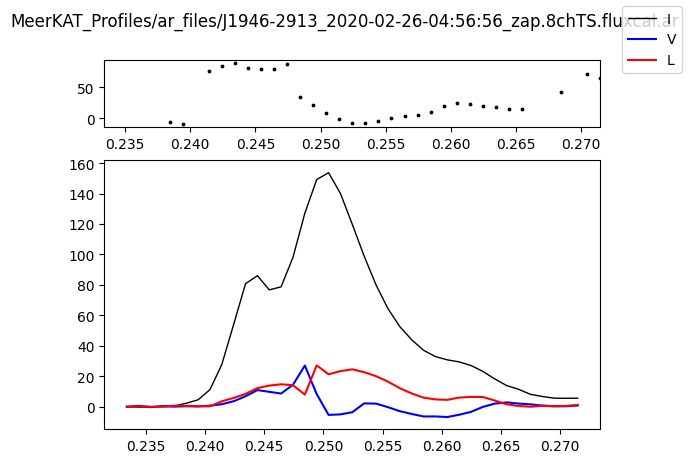

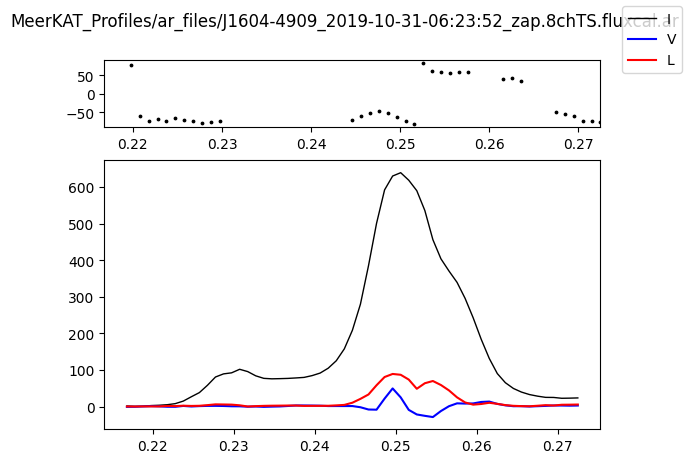

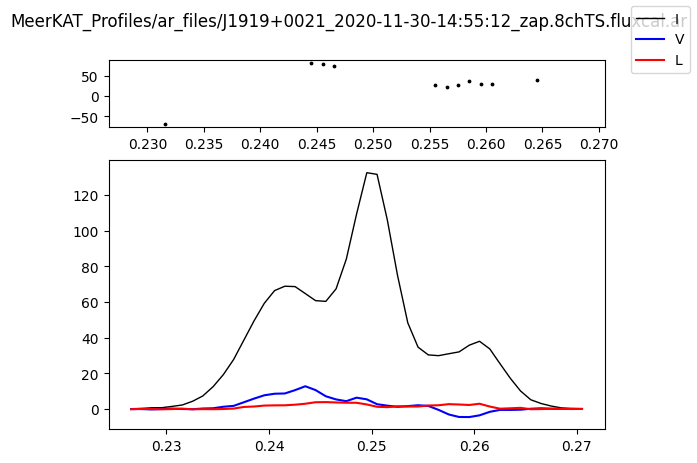

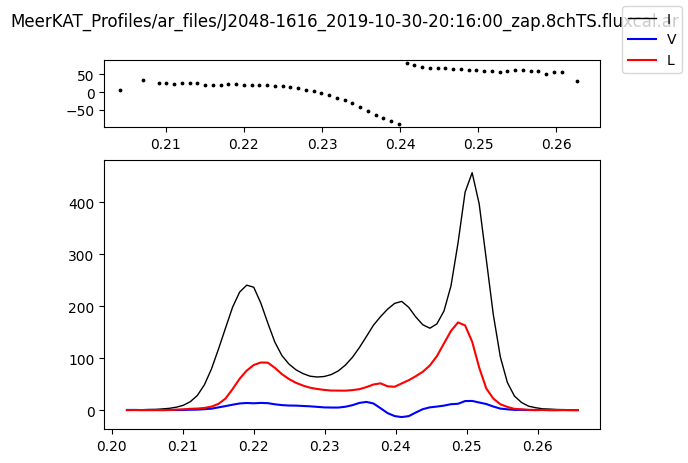

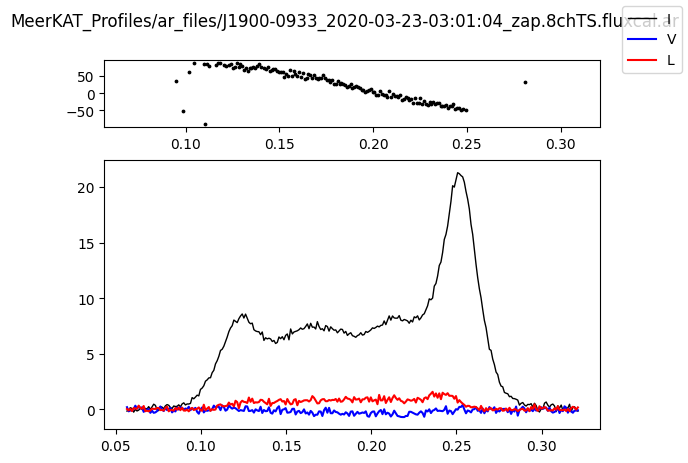

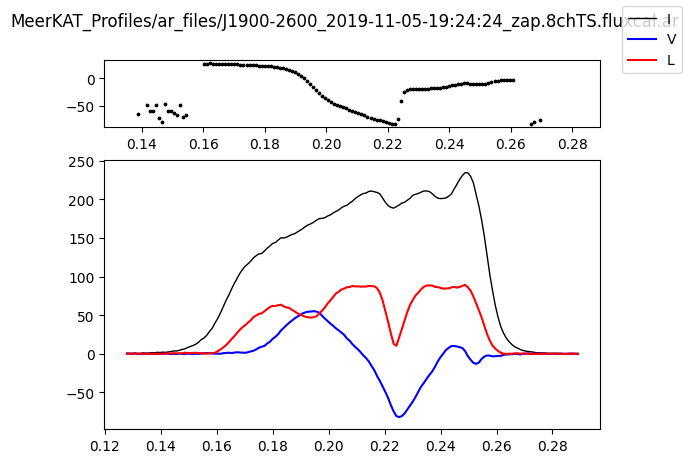

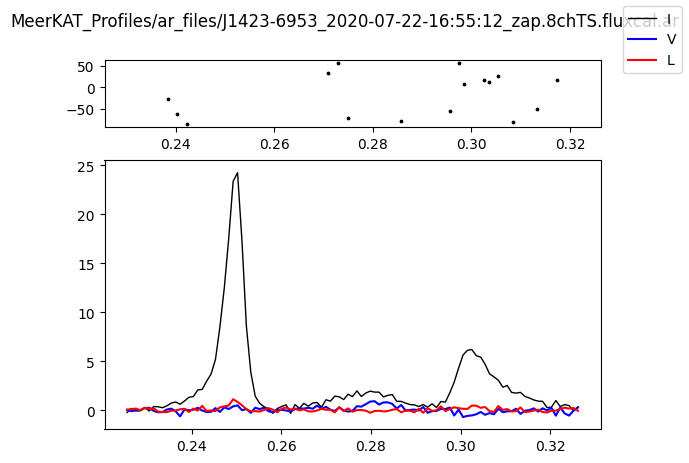

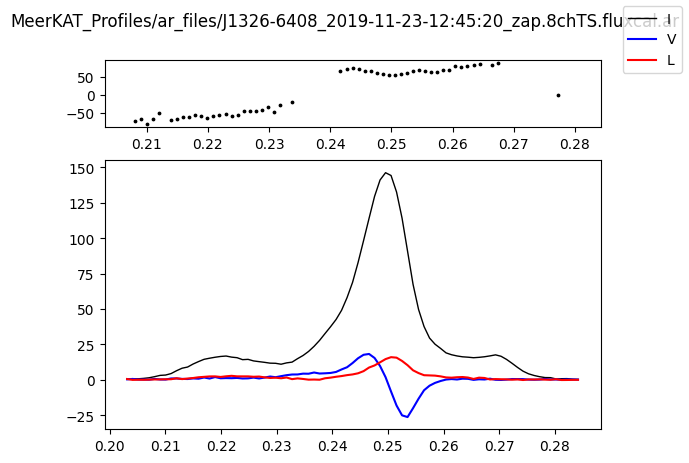

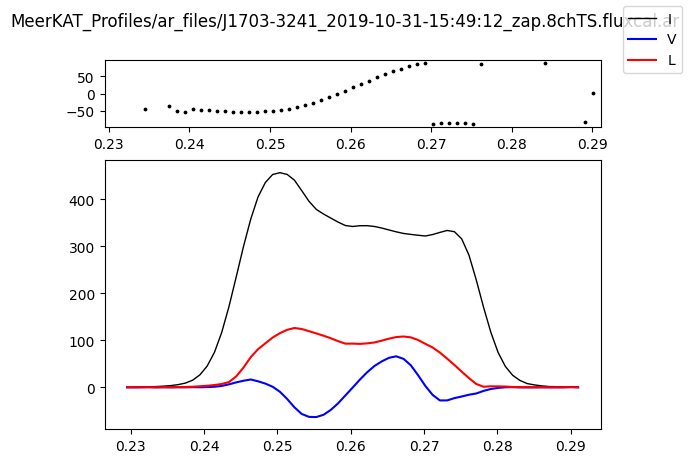

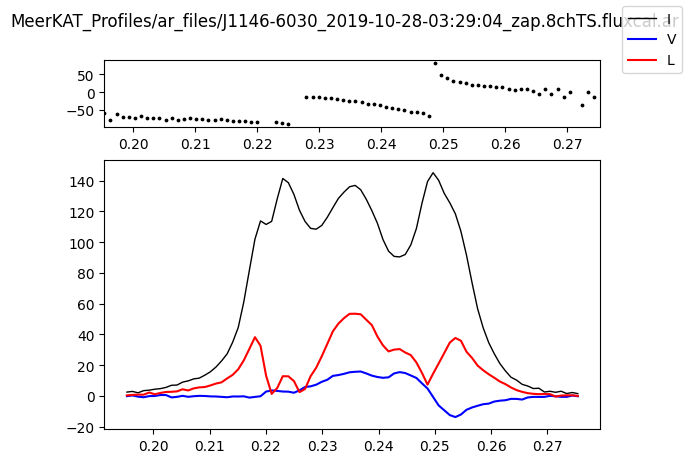

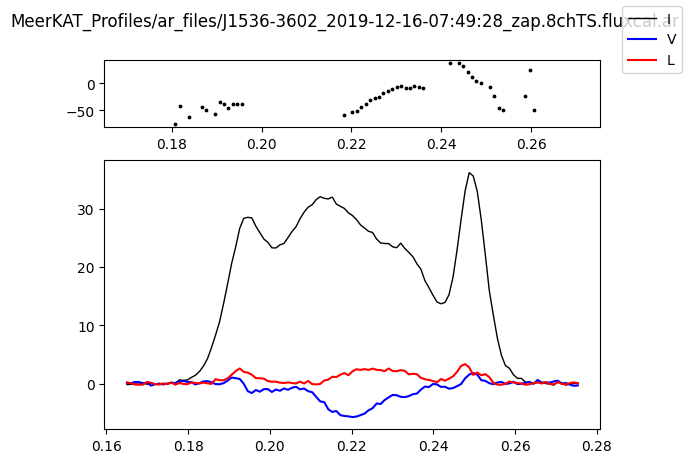

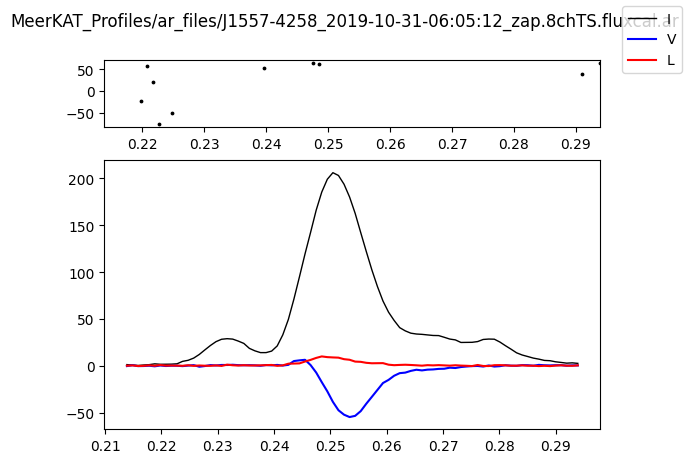

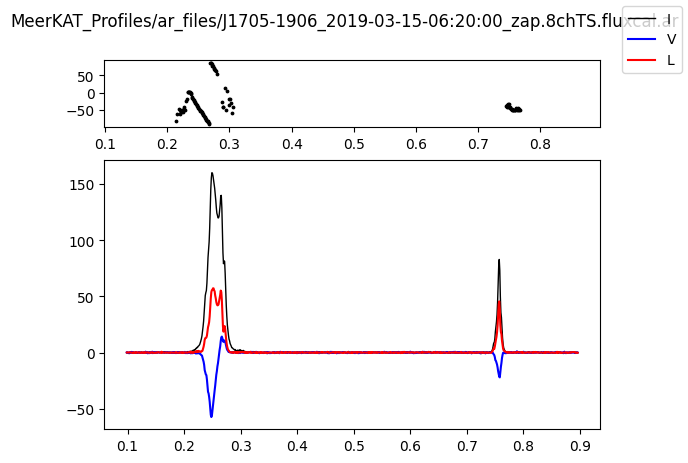

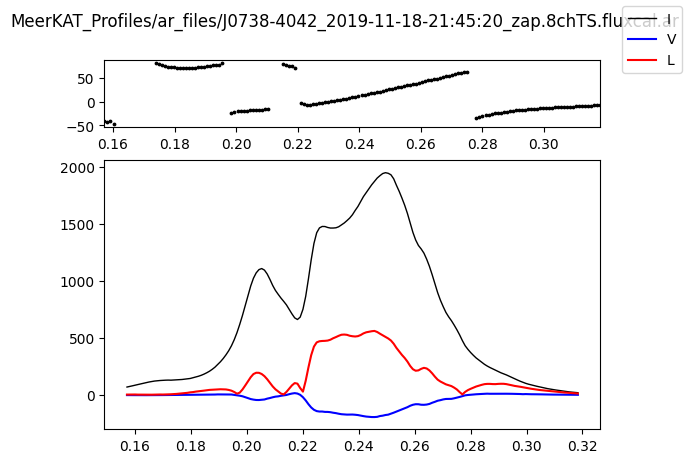

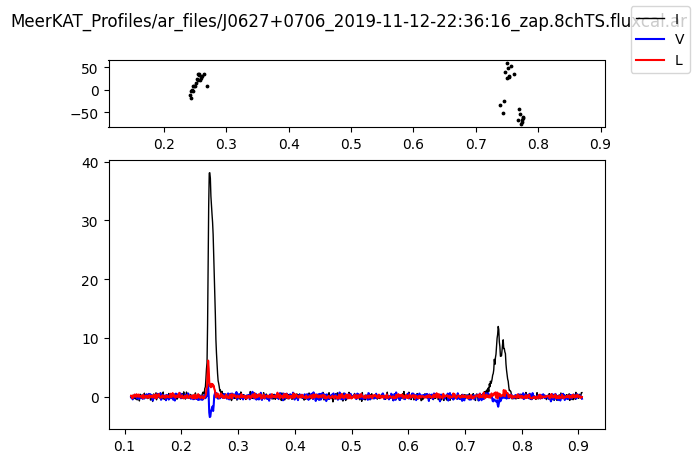

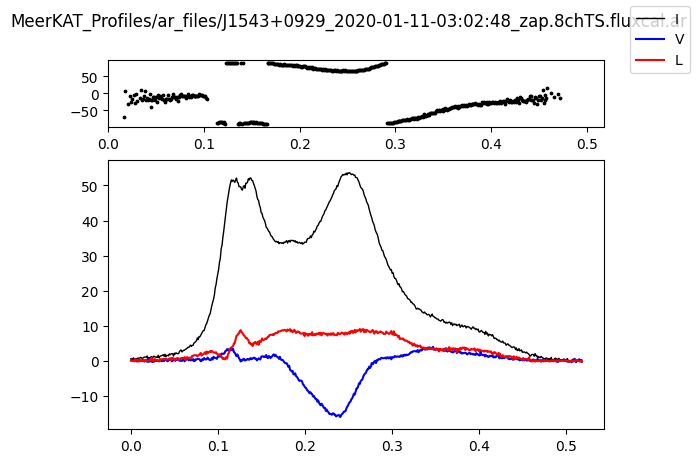

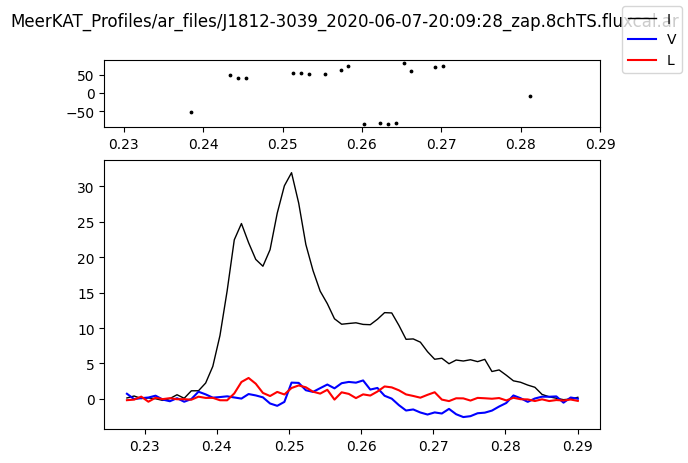

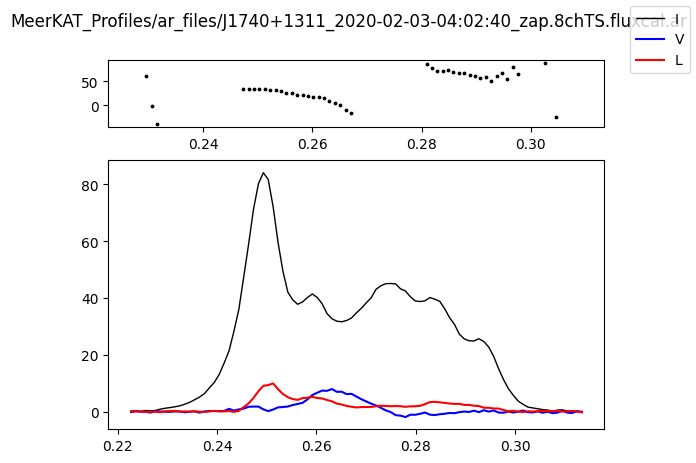

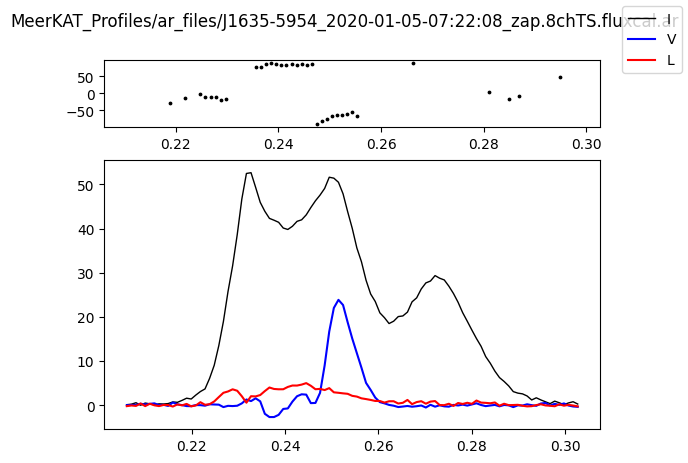

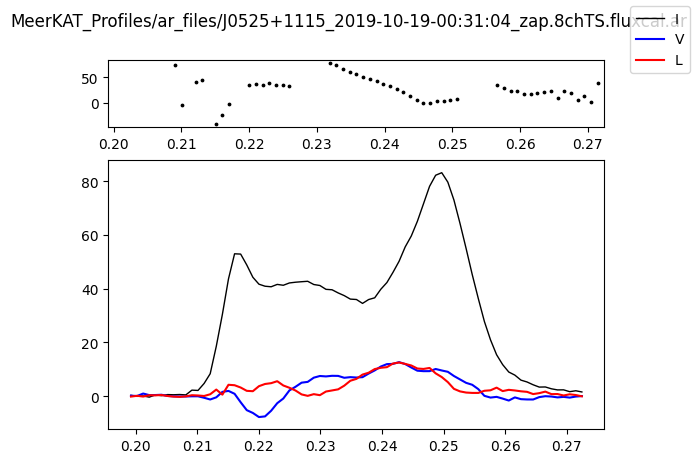

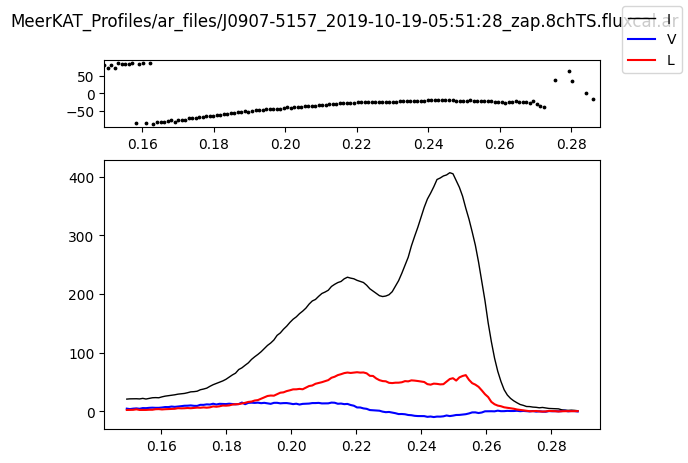

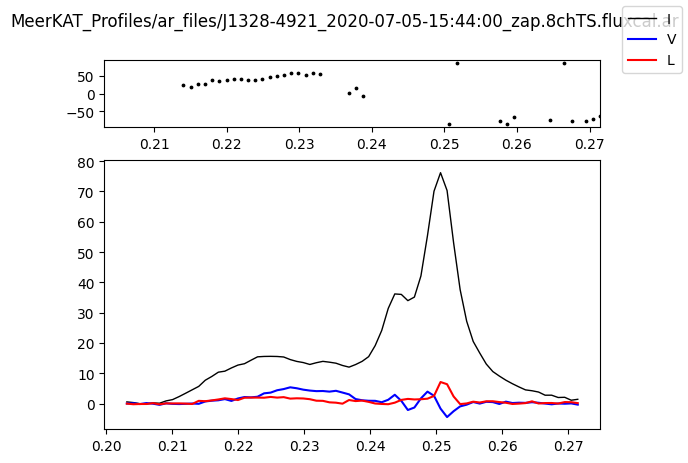

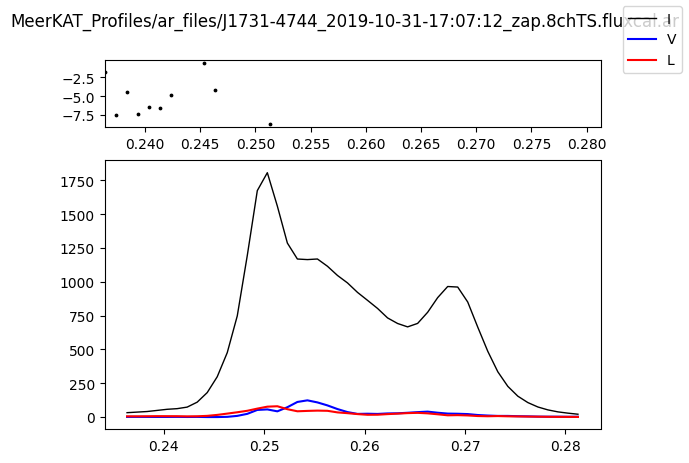

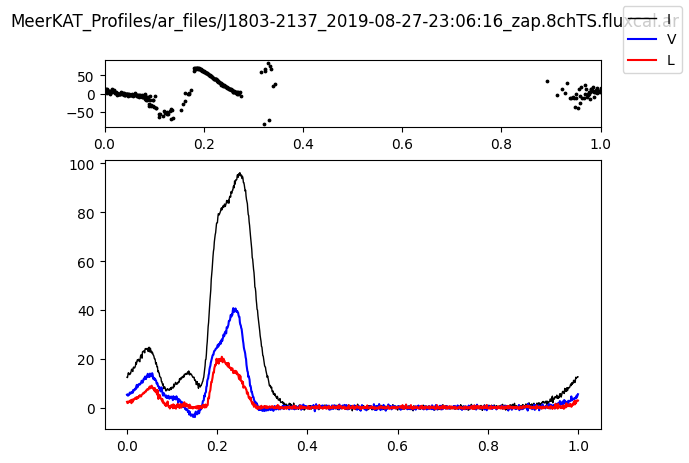

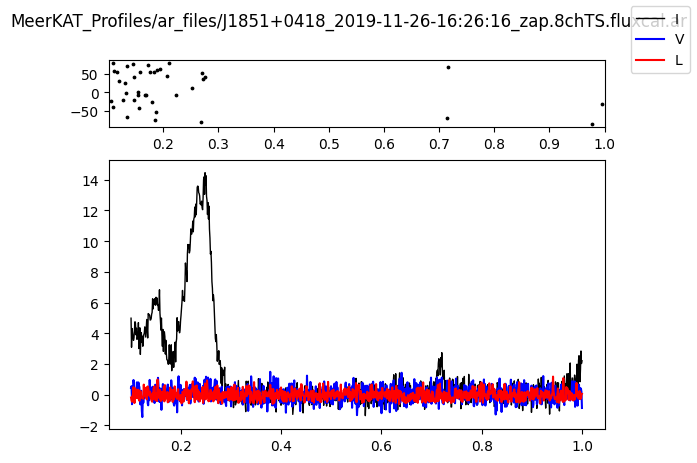

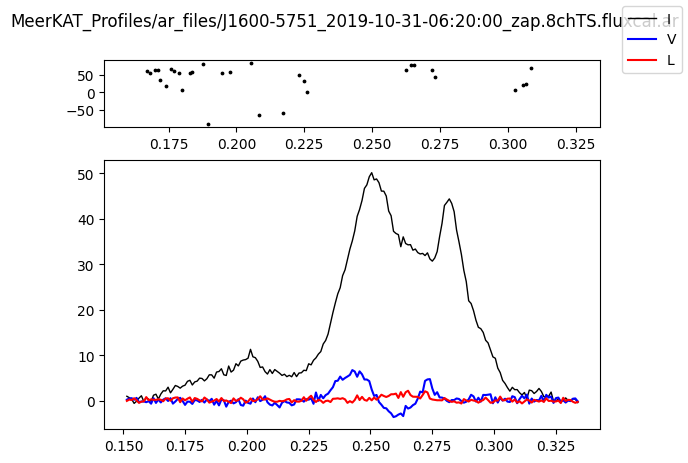

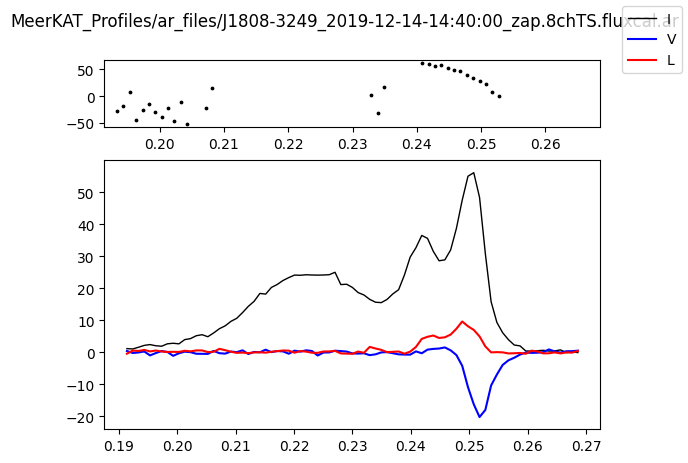

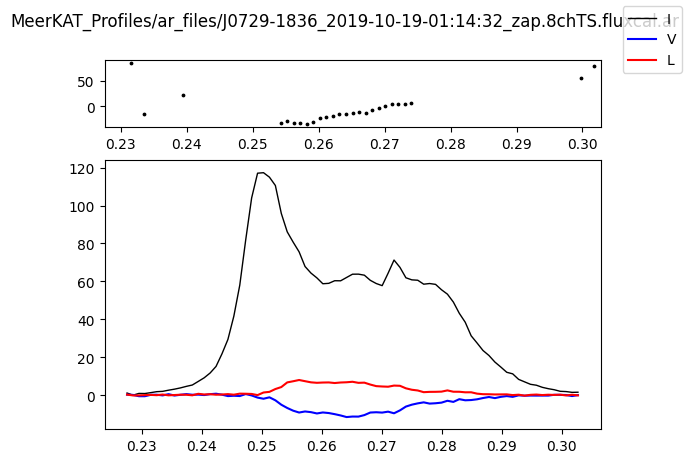

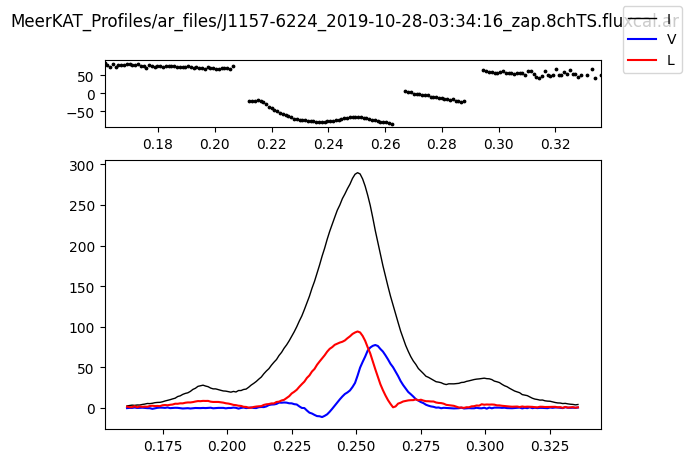

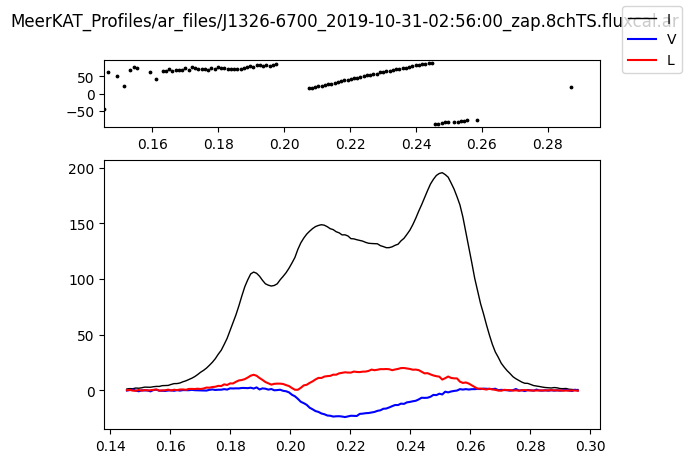

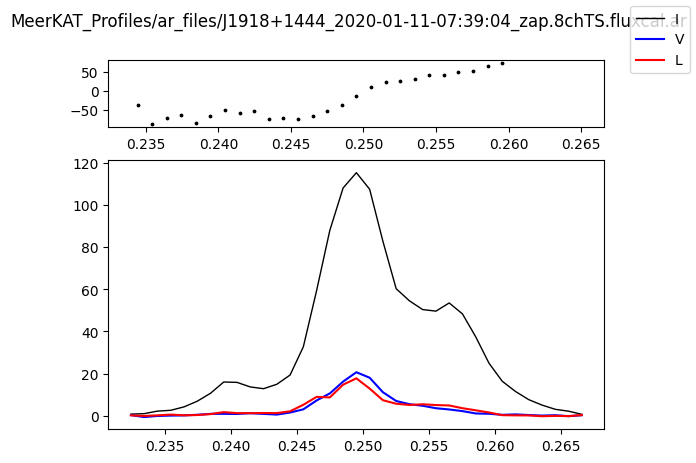

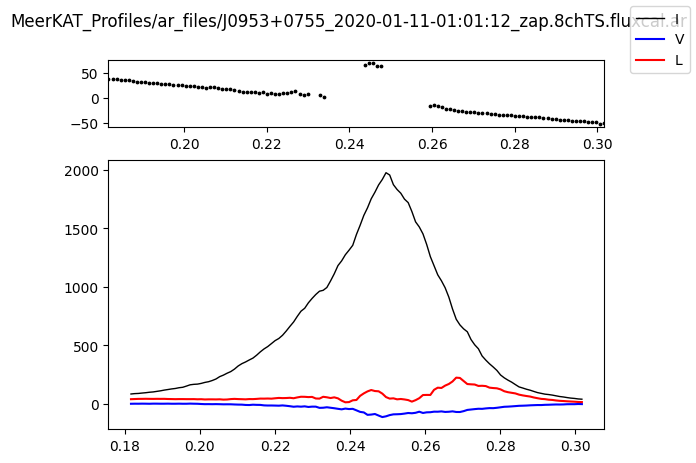

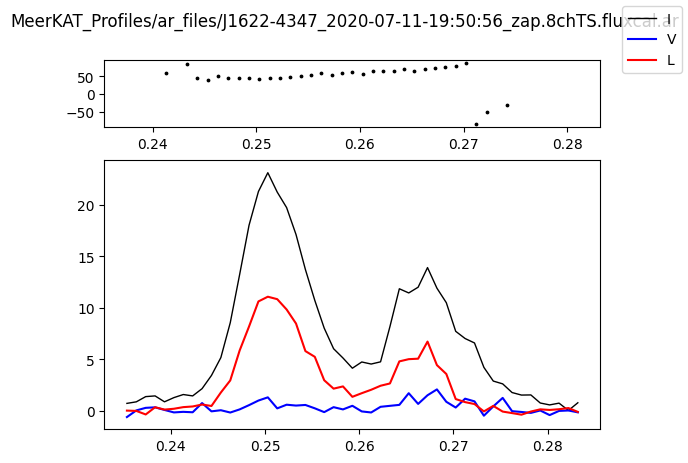

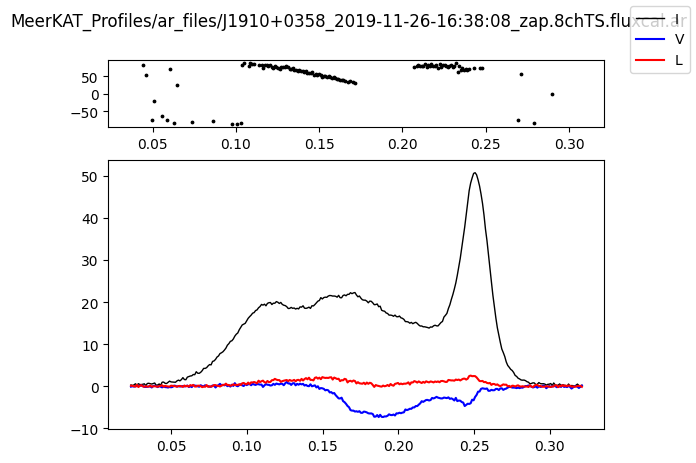

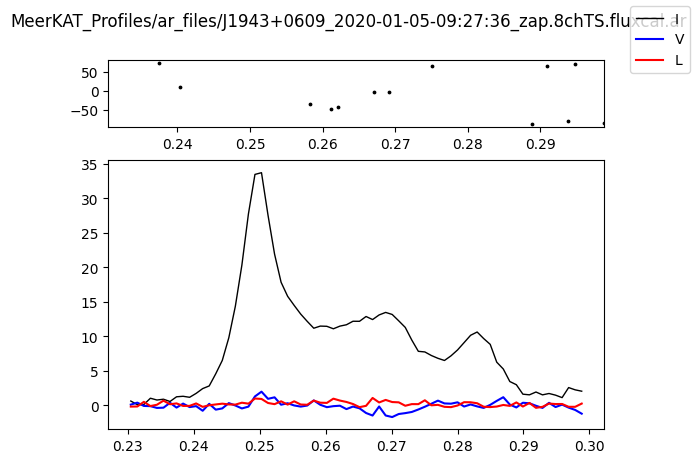

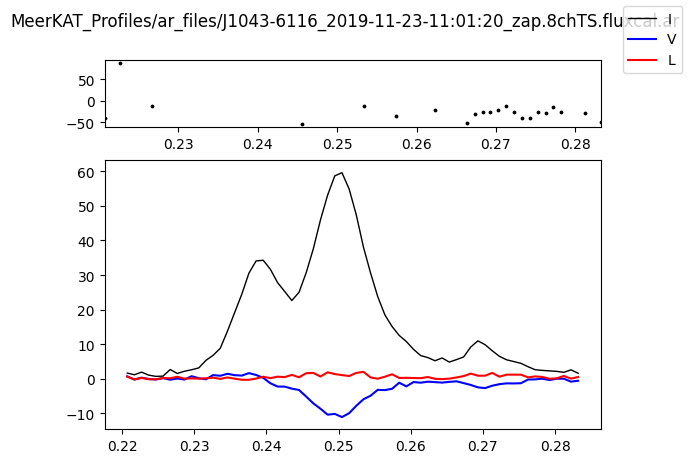

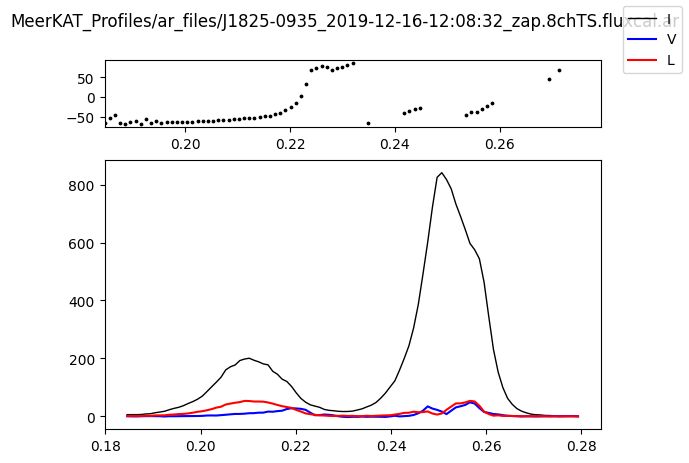

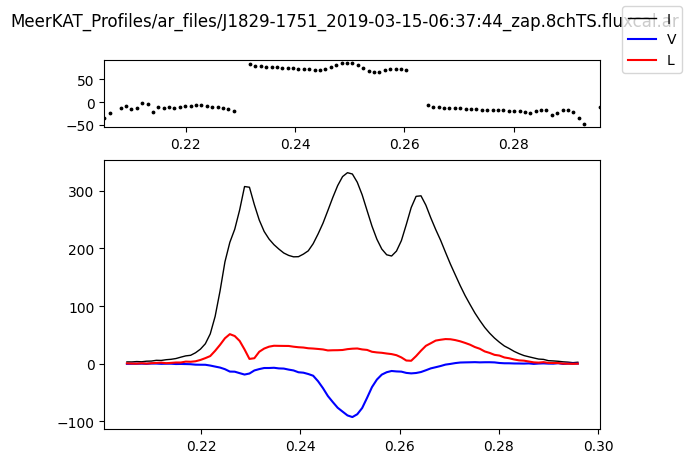

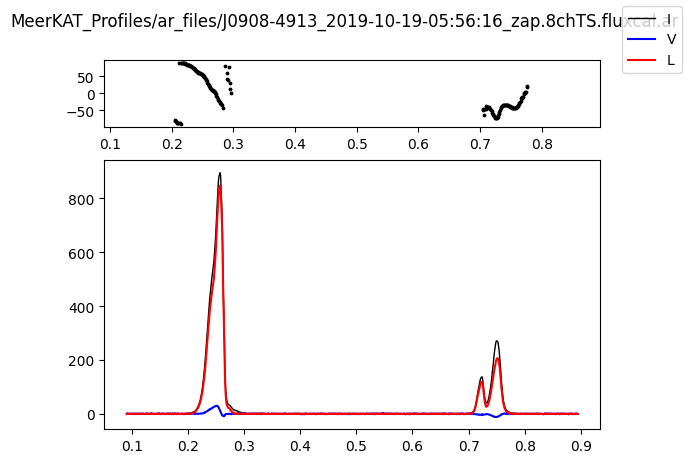

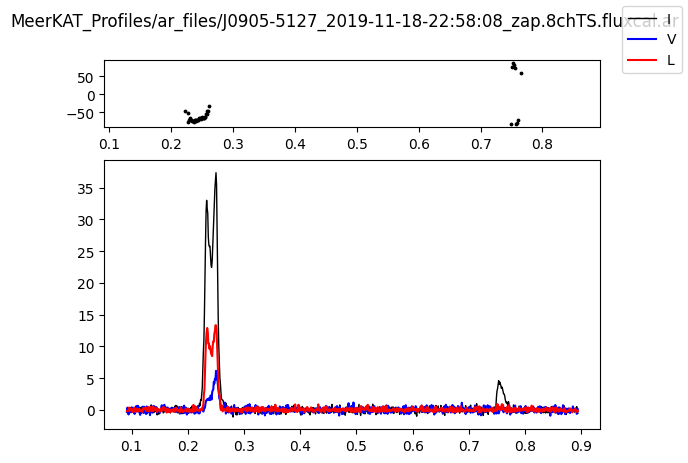

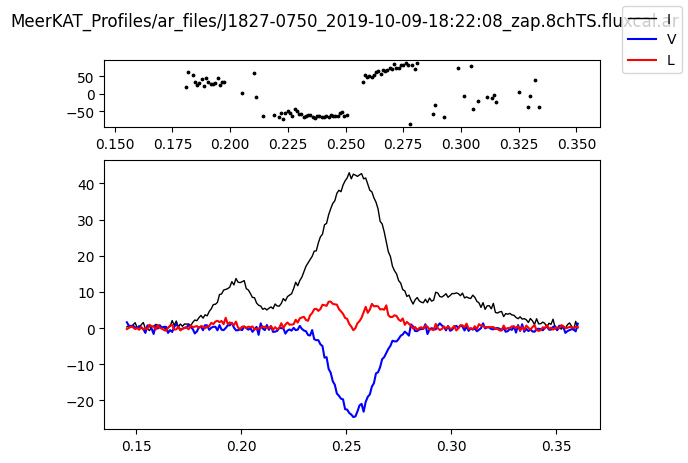

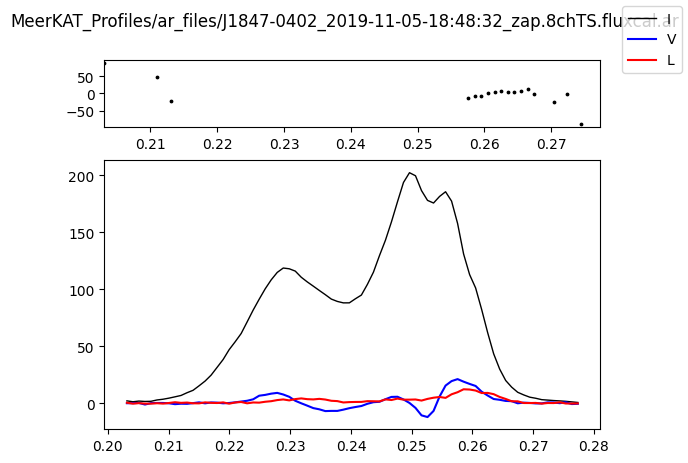

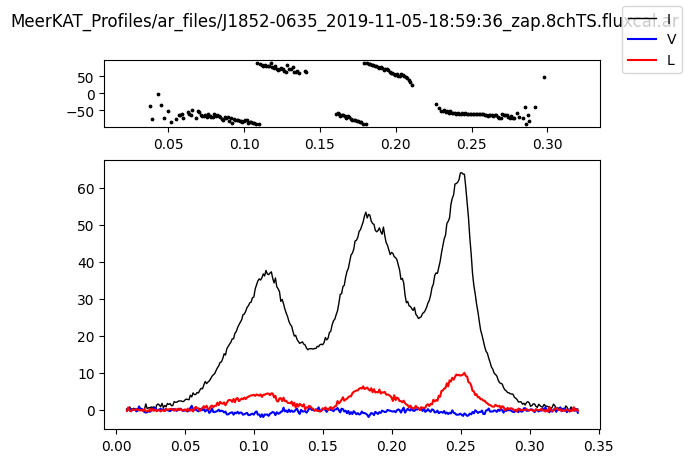

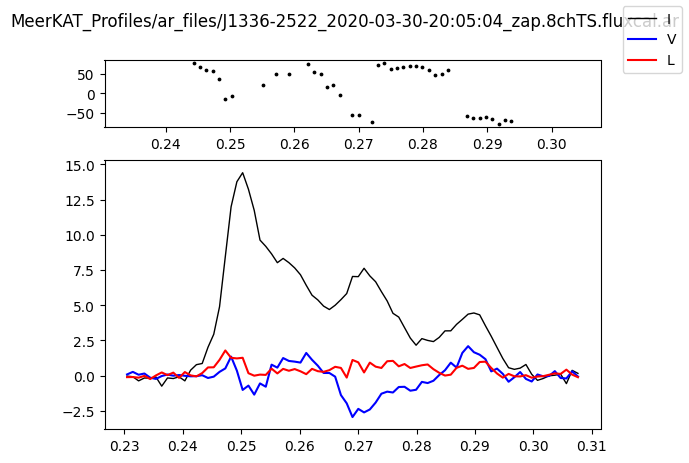

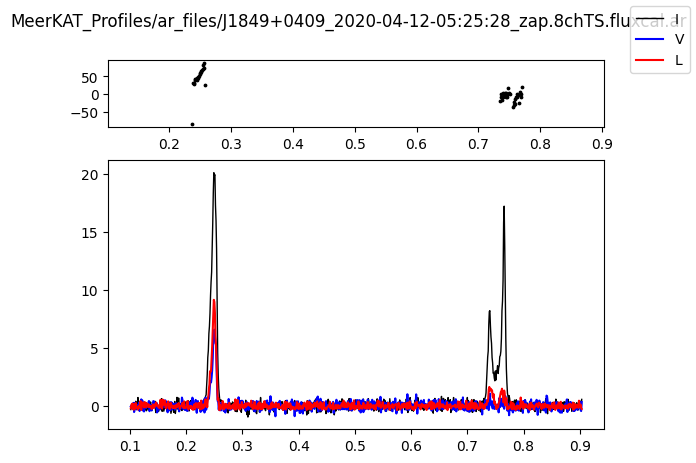

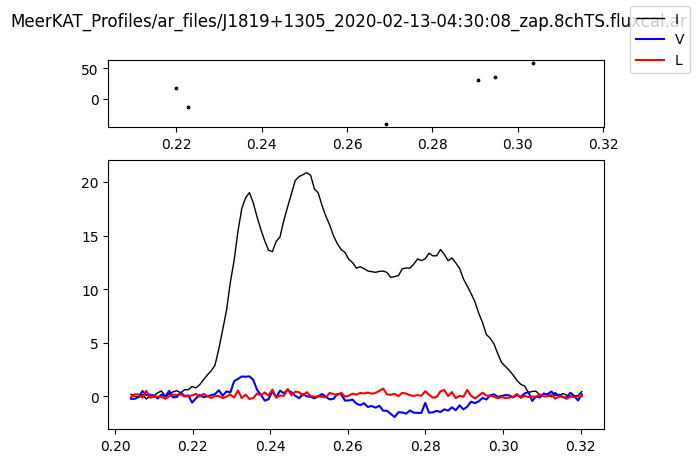

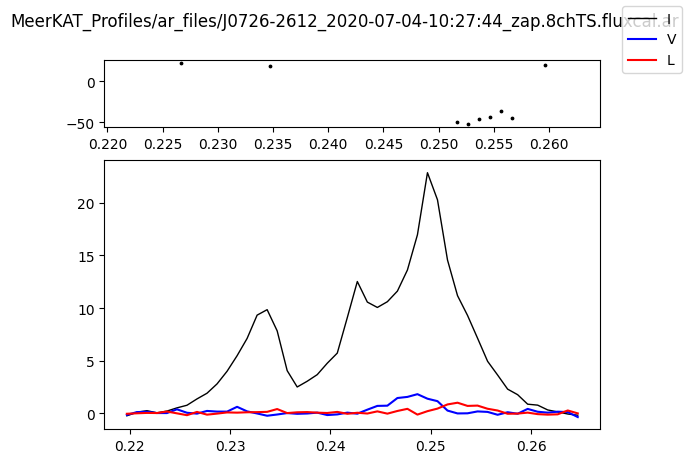

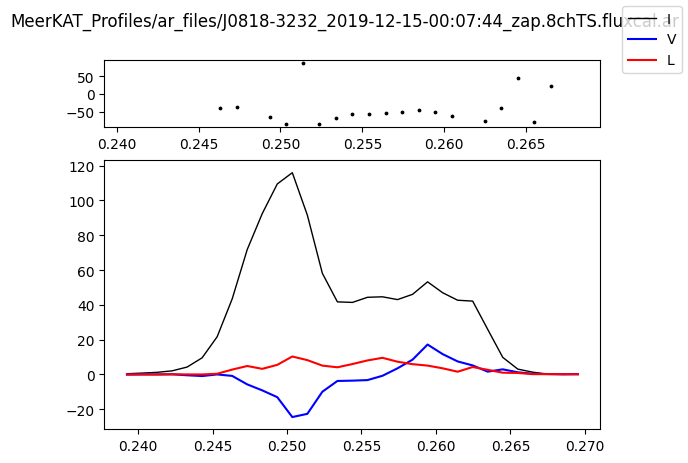

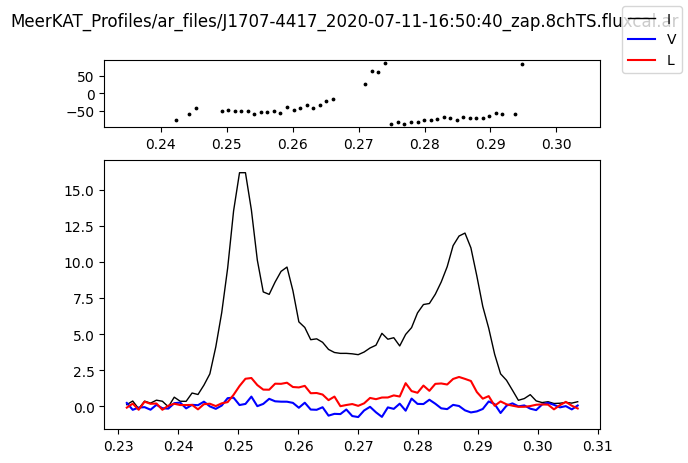

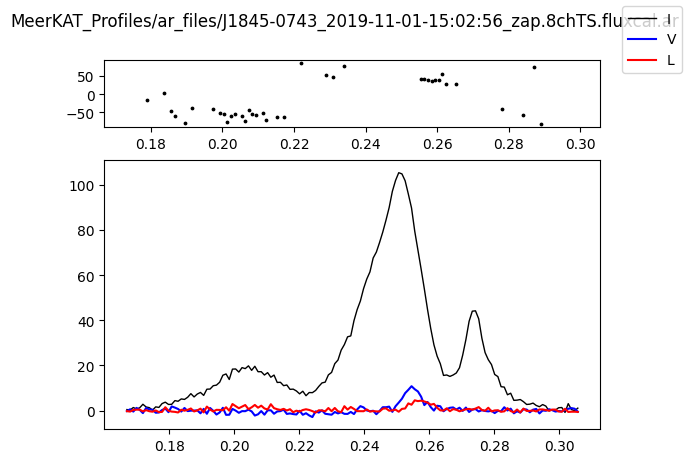

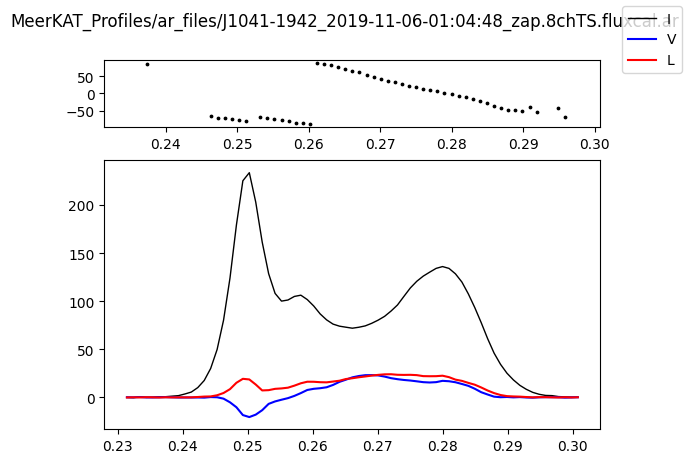

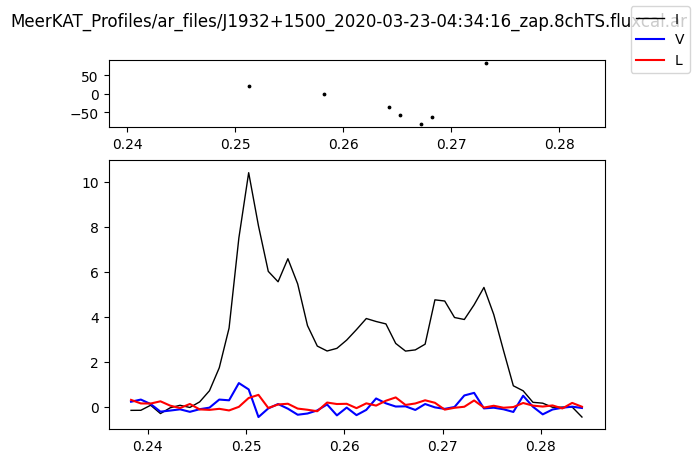

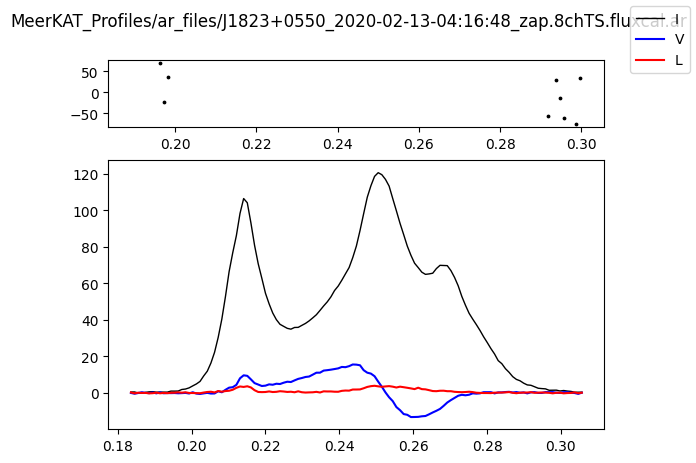

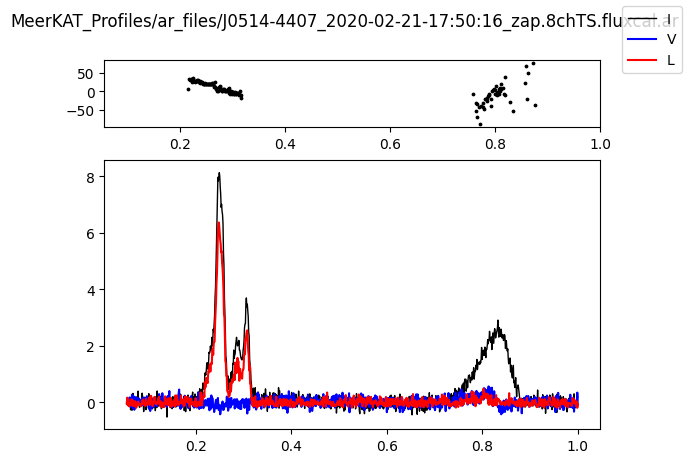

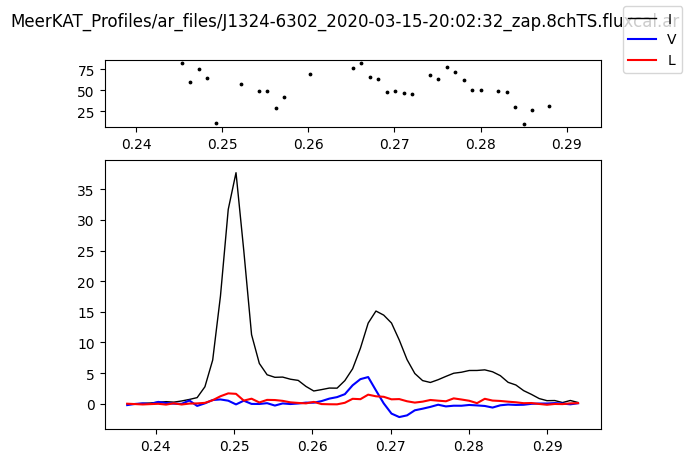

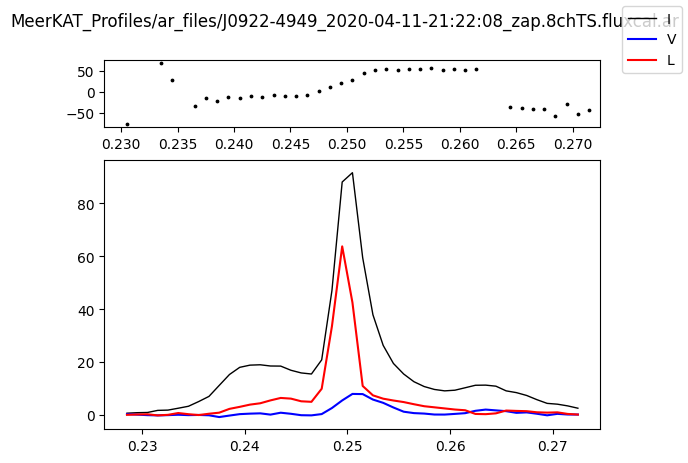

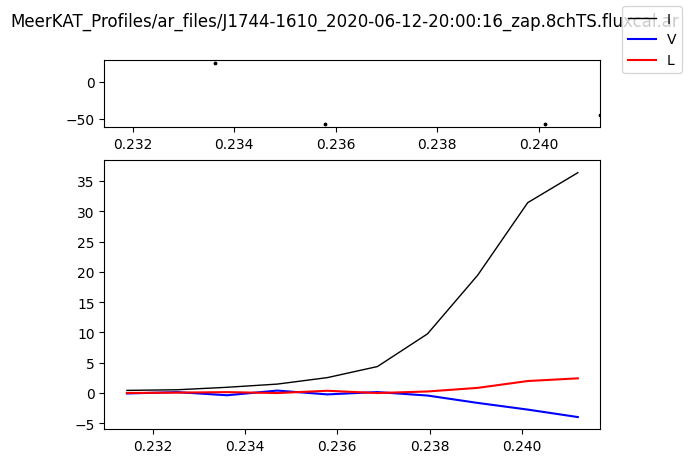

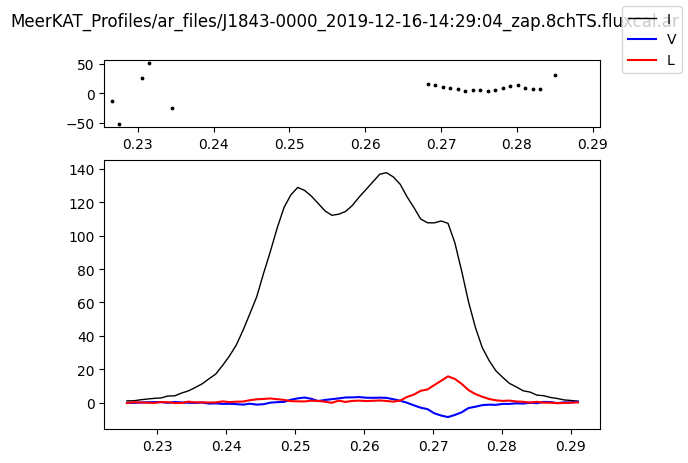

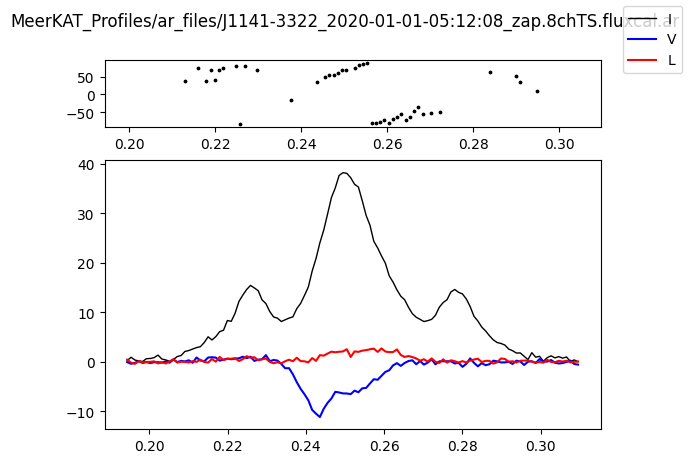

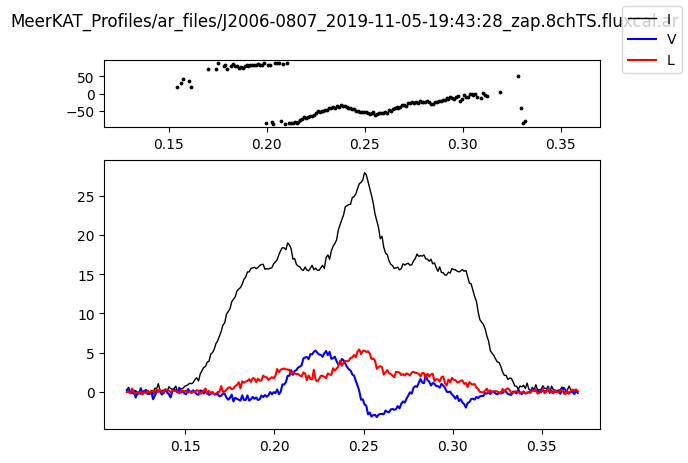

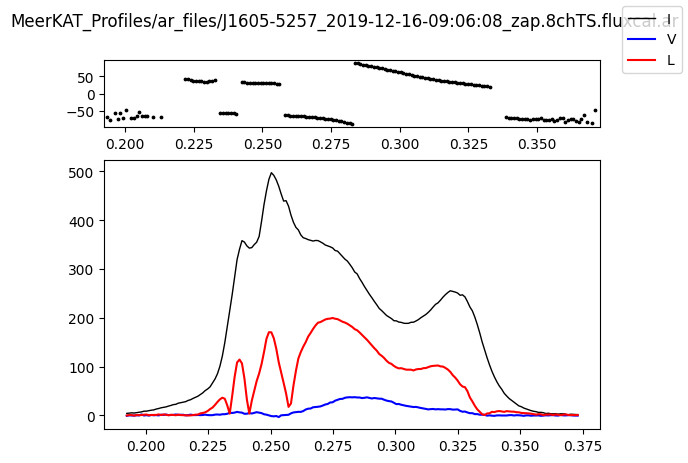

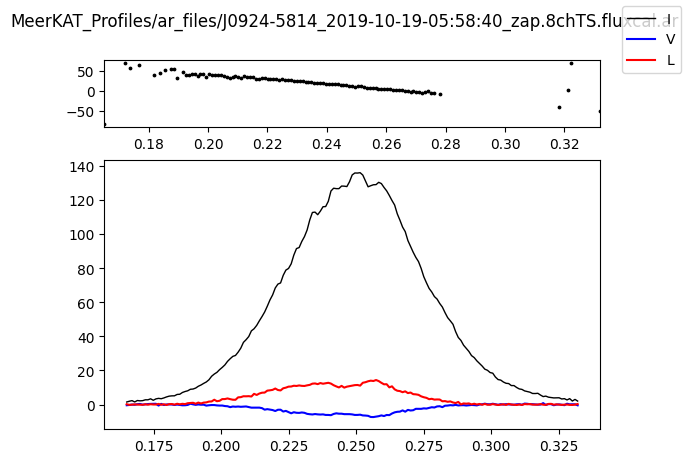

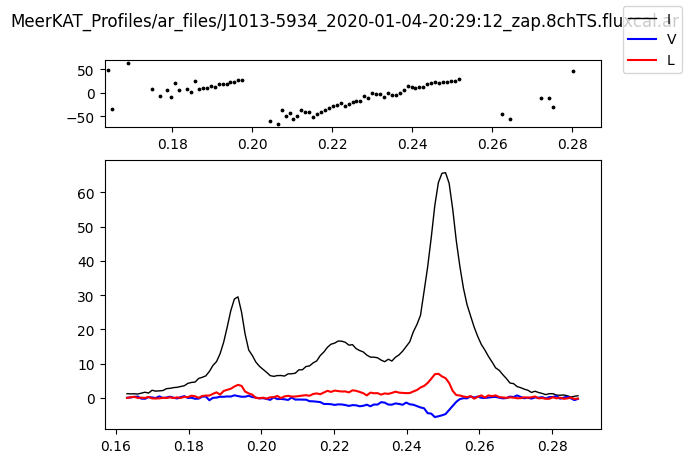

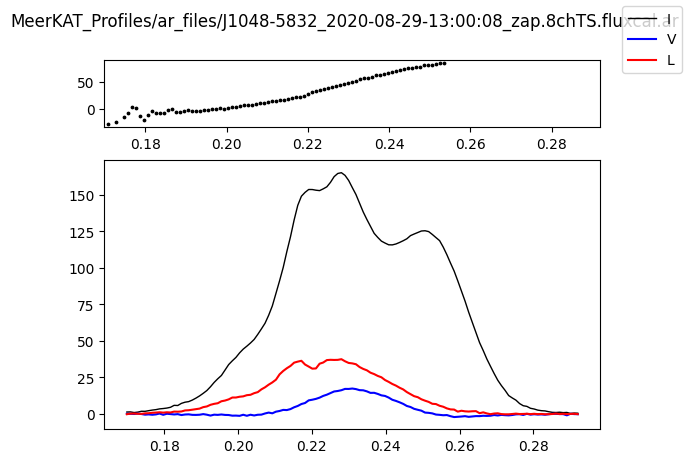

In [80]:
for psr in TrippleHumped:
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['file_name'], 'MeerKAT')
    fig, axs = profile.plot_profile(zoom=True)
    fig.savefig('TrippleProfiles/' + psr + '.pdf')

## Width-frequency dependence

In [104]:
pl_inds_X = []
pl_inds_O = []
for index, psr in MeerKATProfiles.iterrows():
    if not (index in data.index):
        continue
    if data.loc[index]['P0'] < 0.03:
        continue
    if psr['Mode'] == 'Xd' or psr['Mode'] == 'Od':
        freqs = []
        widths = []
        for i in range(8):
            profile = PulsarProfile(psr['file_name'], 'MeerKAT_one_channel', i)
            freqs.append(profile.freq)
            widths.append(profile.get_Wa(20))
        pl_ind, corr = aux.find_pl_ind(freqs, widths)
        print(index, pl_ind, corr)
        if np.abs(corr) > 0.8:
            if psr['Mode'] == 'Xd':
                pl_inds_X.append(pl_ind)
            if psr['Mode'] == 'Od':
                pl_inds_O.append(pl_ind)
    # profile = PulsarProfile(psr['file_name'], 'MeerKAT_one_channel', 0)
    # if profile. find_profile_type() == 'single':
    #     mode = profile.get_mode()
    #     if mode != '?':
    #         freqs = []
    #         widths = []
    #         for i in range(8):
    #             profile = PulsarProfile(psr['file_name'], 'MeerKAT_one_channel', i)
    #             freqs.append(profile.freq)
    #             widths.append(profile.get_Wa(50))
    #         pl_ind, corr = aux.find_pl_ind(freqs, widths)
    #         print(index, pl_ind, corr)
    #         if np.abs(corr) > 0.8:
    #             if mode == 'X':
    #                 pl_inds_X.append(pl_ind)
    #             if mode == 'O':
    #                 pl_inds_O.append(pl_ind)  




J2253+1516 0.005638576557287194 0.10833947958875119
J0536-7543 -0.08263634454454323 -0.8925939773323838
J1927+2234 0.23959225551806113 0.8617092594171902
J1945-0040 0.1408992944607742 0.9364175660106712
J1906+0641 -0.9314861772852967 -0.9956215740947563
J1527-3931 0.011767071050750692 0.09997833410304997
J1259-6741 -0.022018757832019984 -0.3944549026163085
J2048-1616 -0.08677776309721512 -0.9897004568136131
J1718-3825 -0.03745040962325526 -0.06870890975755238
J2005-0020 nan nan
J1734-0212 0.7572361256474418 0.7605534498006037
J1703-3241 -0.07695944228312605 -0.9867787186632158
J1757-1500 0.41281236392336684 0.5994802632279378
J1536-3602 -0.004320817574173628 -0.05349486337713818
J2045+0912 0.4238918193799859 0.4329622072785932
J0633-2015 -0.4730257521391843 -0.7636221382267349
J1537-4912 0.031283611748233006 0.30062514568645843
J1740+1000 -0.4137286022751568 -0.9917477592509112
J1751-4657 -0.058135372258277015 -0.978768670893145
J1705-1906 0.005395056062426498 0.6098068823420099
J1837-

-0.05921175400601783


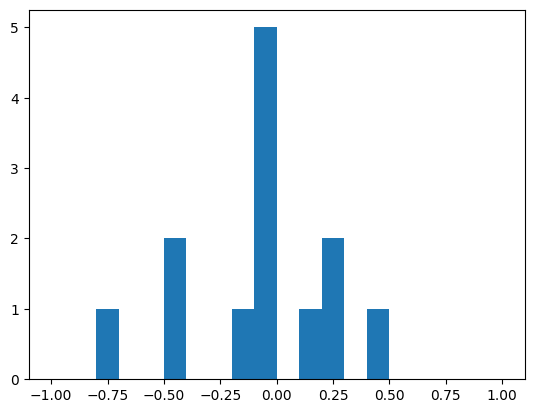

In [105]:
plt.hist(pl_inds_X, range=(-1, 1), bins=20)
# print(np.nanmedian(pl_inds_O))
print(np.nanmedian(pl_inds_X))


-0.09632748815328729


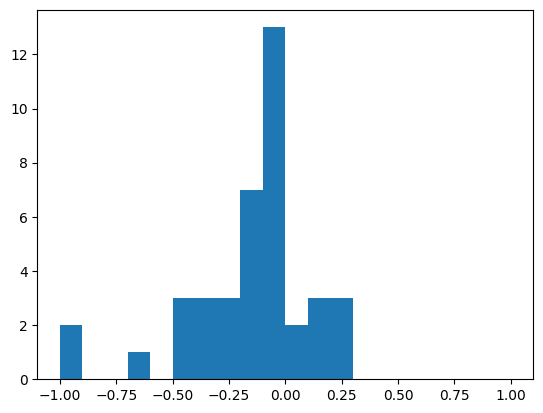

In [106]:
plt.hist(pl_inds_O, range=(-1, 1), bins=20)
print(np.nanmedian(pl_inds_O))


In [64]:
freqs = []
widths = []
for i in range(8):
    profile = PulsarProfile(MeerKATProfiles.loc['J1709-4429']['file_name'], 'MeerKAT_one_channel', i)
    print(profile.get_Wa(50), profile.freq)
    freqs.append(profile.freq)
    widths.append(profile.get_Wa(50))


23.94140625 947459028.4746614
23.4140625 1038045158.5238059
23.2734375 1142407873.7381234
22.640625 1234905080.3349662
22.359375 1332068465.7729948
22.21875 1429048956.8348403
22.1484375 1523519712.3015873
21.90234375 1617702506.7830286


In [65]:
print(aux.find_pl_ind(freqs, widths))

-0.16551383752955684



# To plot

In [ ]:
profile_data = read_profile_data(FASTProfiles.loc['J1851+0118']['FASTfile_name'], 'FAST')
print(find_profile_type(profile_data[0]))
# profile_data[0] = scipy.ndimage.gaussian_filter1d(profile_data[0], profile_data[0].shape[0] // 500 + 1, mode='nearest')
phase = np.linspace(-0.5, 0.5, profile_data[0].shape[0])
noise = noise_estimation(profile_data[0])
spl = scipy.interpolate.splrep(phase, profile_data[0], s=profile_data[0].shape[0]*noise**2)
I_func = scipy.interpolate.BSpline(*spl)
plt.plot(phase, profile_data[0])
plt.plot(phase, profile_data[1])
plt.plot(phase, profile_data[2])
plt.plot(phase, I_func(phase))
peaks = find_peaks_number(profile_data[0])
# # print(find_peaks_number(I_func(phase)))
# # peaks, info = scipy.signal.find_peaks(I_func(phase), prominence=np.max(profile_data[0] * 0.05), height=4 * noise)
# print(noise_estimation(profile_data[0])*4)
for peak in peaks:
    plt.axvline(phase[peak], c='r')

## Mean angles estimation

In [ ]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()
print(MeerKATsubset[MeerKATsubset['P0'] <= 0.033].shape)
print(MeerKATsubset[(MeerKATsubset['P0'] > 0.033) & (MeerKATsubset['P0'] <= 0.5)].shape)
print(MeerKATsubset[(MeerKATsubset['P0'] > 0.5) & (MeerKATsubset['P0'] <= 1.0)].shape)
print(MeerKATsubset[MeerKATsubset['P0'] > 1.0].shape)

In [ ]:
MeerKATsubset['CHI'] = np.arcsin(5 * MeerKATsubset['P0']**(-0.5) / MeerKATsubset['W50']) * 180 / np.pi
FASTsubset['CHI'] = np.arcsin(5 * FASTsubset['P0']**(-0.5) / FASTsubset['W50']) * 180 / np.pi


In [ ]:
Ps = np.arange(0, 2.1, 0.5)

av_chis = np.zeros(Ps.shape[0]-1)
av_chisXs = np.zeros(Ps.shape[0]-1)
av_chisOs = np.zeros(Ps.shape[0]-1)
Ns_all = np.zeros(Ps.shape[0]-1)
Ns_Os = np.zeros(Ps.shape[0]-1)
Ns_Xs = np.zeros(Ps.shape[0]-1)

for i in range(Ps.shape[0]-1):
    av_chisXs[i] = MeerKATXs[(MeerKATXs['P0'] >= Ps[i]) & (MeerKATXs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Xs[i] =  MeerKATXs[(MeerKATXs['P0'] >= Ps[i]) & (MeerKATXs['P0'] < Ps[i+1])].count()['CHI']
    av_chisOs[i] = MeerKATOs[(MeerKATOs['P0'] >= Ps[i]) & (MeerKATOs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Os[i] =  MeerKATOs[(MeerKATOs['P0'] >= Ps[i]) & (MeerKATOs['P0'] < Ps[i+1])].count()['CHI']
    av_chis[i] = MeerKATsubset[(MeerKATsubset['P0'] >= Ps[i]) & (MeerKATsubset['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_all[i] = MeerKATsubset[(MeerKATsubset['P0'] >= Ps[i]) & (MeerKATsubset['P0'] < Ps[i+1])].count()['CHI']
    
    

In [ ]:
plt.errorbar(Ps[:-1], av_chis, 15/np.sqrt(Ns_all), c='orange', label='All', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisXs, 15/np.sqrt(Ns_Xs), c='blue', label='X', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisOs, 15/np.sqrt(Ns_Os), c='green', label='O', fmt='o', capsize=3)

plt.xlabel('P', size=14)
plt.ylabel(r'$<\chi>$', size=14)
plt.title('MeerKAT', size=18)
plt.legend()
plt.savefig('MeerKAT_mean_angles.png', dpi=400)

In [ ]:
Ps = np.arange(0, 2.1, 0.5)

av_chis = np.zeros(Ps.shape[0]-1)
av_chisXs = np.zeros(Ps.shape[0]-1)
av_chisOs = np.zeros(Ps.shape[0]-1)
Ns_all = np.zeros(Ps.shape[0]-1)
Ns_Os = np.zeros(Ps.shape[0]-1)
Ns_Xs = np.zeros(Ps.shape[0]-1)

for i in range(Ps.shape[0]-1):
    av_chisXs[i] = FASTXs[(FASTXs['P0'] >= Ps[i]) & (FASTXs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Xs[i] =  FASTXs[(FASTXs['P0'] >= Ps[i]) & (FASTXs['P0'] < Ps[i+1])].count()['CHI']
    av_chisOs[i] = FASTOs[(FASTOs['P0'] >= Ps[i]) & (FASTOs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Os[i] =  FASTOs[(FASTOs['P0'] >= Ps[i]) & (FASTOs['P0'] < Ps[i+1])].count()['CHI']
    av_chis[i] = FASTsubset[(FASTsubset['P0'] >= Ps[i]) & (FASTsubset['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_all[i] = FASTsubset[(FASTsubset['P0'] >= Ps[i]) & (FASTsubset['P0'] < Ps[i+1])].count()['CHI']
    
    

In [ ]:
plt.errorbar(Ps[:-1], av_chisXs, 15/np.sqrt(Ns_Xs), c='blue', label='X', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisOs, 15/np.sqrt(Ns_Os), c='green', label='O', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chis, 15/np.sqrt(Ns_all), c='orange', label='All', fmt='o', capsize=3)

plt.xlabel('P', size=14)
plt.ylabel(r'$<\chi>$', size=14)
plt.title('FAST', size=18)
plt.legend()
plt.savefig('FAST_mean_angles.png', dpi=400)

## Orthogonals analysis

In [409]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
orthogonalMeerKATs = data[data.index.isin(orthogonal_PSRs_MeerKAT)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()
orthogonalFASTs = data[data.index.isin(orthogonal_PSRs_FAST)].copy()

In [412]:
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] < 0.03)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.03) & (orthogonalMeerKATs['P0'] < 0.1)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.1) & (orthogonalMeerKATs['P0'] < 0.2)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.2) & (orthogonalMeerKATs['P0'] < 0.3)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.3) & (orthogonalMeerKATs['P0'] < 0.4)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.4) & (orthogonalMeerKATs['P0'] < 0.5)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.5)]))

0
2
7
9
6
1
4


In [413]:
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] < 0.03)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.03) & (orthogonalFASTs['P0'] < 0.1)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.1) & (orthogonalFASTs['P0'] < 0.2)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.2) & (orthogonalFASTs['P0'] < 0.3)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.3) & (orthogonalFASTs['P0'] < 0.4)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.4) & (orthogonalFASTs['P0'] < 0.5)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.5)]))

13
1
5
6
3
2
4


In [452]:
P1 = 0.033
P2 = 0.5
print('MeerKAT')
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > P1) & (orthogonalMeerKATs['P0'] < P2)]) / (len(MeerKATsubset[(MeerKATsubset['P0'] > P1) & (MeerKATsubset['P0'] < P2)]))*100)
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > P1) & (orthogonalMeerKATs['P0'] < P2)]))
print((len(MeerKATsubset[(MeerKATsubset['P0'] > P1) & (MeerKATsubset['P0'] < P2)])))
print('FAST')
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > P1) & (orthogonalFASTs['P0'] < P2)]) / (len(FASTsubset[(FASTsubset['P0'] > P1) & (FASTsubset['P0'] < P2)]))*100)
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > P1) & (orthogonalFASTs['P0'] < P2)]))
print(len(FASTsubset[(FASTsubset['P0'] > P1) & (FASTsubset['P0'] < P2)]))


MeerKAT
3.5593220338983054
21
590
FAST
7.296137339055794
17
233


In [ ]:
MeerKATdivs = []
for psr in orthogonal_PSRs_MeerKAT:
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['MeerKATfile_name'], 'MeerKAT')
    peaks = profile.find_peaks()
    MeerKATdivs.append(np.min(peaks) / np.max(peaks))


In [ ]:
FASTdivs = []
for psr in orthogonal_PSRs_FAST:
    profile = PulsarProfile(FASTProfiles.loc[psr]['FASTfile_name'], 'FAST')
    peaks = profile.find_peaks()
    FASTdivs.append(np.min(peaks) / np.max(peaks))


In [ ]:
print(f'FAST median = {np.median(FASTdivs)}, MeerKAT median = {np.median(MeerKATdivs)}')

In [ ]:
plt.hist(FASTdivs)
plt.hist(MeerKATdivs)

In [ ]:
import DataLoaders

In [ ]:
test_profile = DataLoaders.load_MeerKAT_mean_data(data.loc['J0835-3707']['MeerKATfile_name'])

In [ ]:
# plt.plot(test_profile[0])
fft_vals = scipy.fft.fft(test_profile[0])